In [1]:
import sys
sys.path.insert(0, "/gpfsdswork/projects/rech/ank/ucv88ce/repos/CPC_torch")
sys.path.insert(0, "/gpfsdswork/projects/rech/ank/ucv88ce/projects/InfTrain/utils")

sys.path.insert(0, "/gpfsdswork/projects/rech/ank/ucv88ce/repos/CPC_torch/cpc/eval")
sys.path.insert(0, "/gpfsdswork/projects/rech/ank/ucv88ce/repos/CPC_torch/cpc/transformers")

sys.path.insert(0, "/gpfsdswork/projects/rech/ank/ucv88ce/repos/WavAugment")

In [2]:
import os
from time import time
import torch
import torchaudio
from cpc.feature_loader import loadModel, getCheckpointData
from cpc.train import getCriterion

In [93]:
from utils.compute_CPC_proba import *
from scipy import stats

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns

#better and bigger plots inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 250 # 200 e.g. is really fine, but slower

sns.set_theme()

## Load CPC model and criterion

In [5]:
# Checkpoint path

def load_model_criterion(pathCheckpoint):
    # Load CPC model
    cpcModel = loadModel([pathCheckpoint])[0].cuda()
    cpcModel.gAR.keepHidden = True
    cpcModel.eval()
    # Load CPC criterion
    cpcCriterion = loadCriterion(pathCheckpoint, cpcModel.gEncoder.DOWNSAMPLING, 7504, None).cuda()
    cpcCriterion.eval()
    print('CPC model and criterion loaded!')
    return cpcModel, cpcCriterion

In [232]:
def compute_score_CPC(seqPath, 
                      cpcModel, 
                      cpcCriterion, 
                      speakerLabel=0,
                      nTemporal=12,
                      logits_scaling=1,
                      reduce_method='sum',
                      prob_estimator='negative_sampling',
                      n_negative_sampling=None, score="logprob"):
    '''
    Comment on some useful args:
        logits_scaling:  put this high to avoid having 0. log proba for near temporal steps when 
                         using sigmoid, but it seems that 1 (default) gives the best results
         reduce_method:  'sum' seems to work best
        prob_estimator:  using 'sigmoid' is faster as we don't need to compute negative samples,
                         but using 'negative_sampling' seems to have better results as this is
                         the way the CPC model is trained (however this will make the scores varying)
   n_negative_sampling:  leave this to 'None' and the model will use 128(defaut) negative samples
    score:                either [accuracy] (mean on 12 frames) or [logprob]
    '''
    assert reduce_method in ['sum', 'mean']
    assert prob_estimator in ['sigmoid', 'negative_sampling']
    with torch.no_grad():
        # Read the input signals
        seq = torchaudio.load(seqPath)[0] # 1 x frames
        seq = seq[:,:].view(1, 1, -1).cuda() # 1 x 1 x frames
        
        # Read CPC features
        cpcModel.gAR.hidden = None
        cFeature, encodedData, label = cpcModel(seq, label=None)
        ## cFeature: 1 x T x D_feat
        ## encodedData: 1 x T x D_enc
        
        # Prepare CPC features for criterion
        batchSize, seqSize, _ = cFeature.size()
        windowSize = seqSize - cpcCriterion.nPredicts # T - 12
        cFeature = cFeature[:, :windowSize] # 1 x (T - 12) x D_feat
        
        # Get positive encoded samples
        if prob_estimator=='negative_sampling':
            if n_negative_sampling is not None:
                cpcCriterion.negativeSamplingExt = n_negative_sampling
            sampledData, _ = cpcCriterion.sampleClean(encodedData, windowSize) # 12 x 1 x (1 + n_negative_sampling) x (T - 12) x D_enc
        else:
            sampledData = getPositiveSamples(encodedData, cpcCriterion.nPredicts) # 12 x 1 x 1 x (T - 12) x D_enc
        
        # Speaker embeddings
        if cpcCriterion.speakerEmb is not None:
            label = torch.tensor(speakerLabel).cuda()
            l_ = label.view(batchSize, 1).expand(batchSize, windowSize) # 1 x (T - 12)
            embeddedSpeaker = cpcCriterion.speakerEmb(l_) # 1 x (T - 12) x D_spkemb
            cFeature = torch.cat([cFeature, embeddedSpeaker], dim=2) # 1 x (T - 12) x (D_feat+D_spkemb)
            
        # Compute the criterion outputs
        predictions = cpcCriterion.wPrediction(cFeature, sampledData) # 12 x 1 x 1 x (T - 12)
        
        if score == "accuracy":
            acc_score = 0
            for outputs in predictions[:nTemporal]:
                acc_score += outputs[0][0].mean() #no neg samples
                #x=0
                #for o in outputs[0]:
                #    x+=o.mean()
                #print(x)
                
            acc_score /= nTemporal
            out_score = acc_score.item()
            
        
        # Compute the pseudo log-probas
        if score == "logprob":
            lp_score = 0.
            for outputs in predictions[:nTemporal]:
                logits = outputs[0]/logits_scaling
                if logits.size(0) == 1:
                    logits = logits.sigmoid()
                else:
                    logits = logits.softmax(0)
                if reduce_method == 'sum':
                    lp_score += logits[0].log().sum()
                elif reduce_method == 'mean':
                    lp_score += logits[0].log().mean()
            lp_score  /= nTemporal
            out_score = lp_score.item()
        
    return out_score, outputs

In [101]:

def compute_score_CPC(seqPath,
                      cpcModel,
                      cpcCriterion,
                      speakerLabel=0,
                      nTemporal=12,
                      logits_scaling=1,
                      reduce_method='sum',
                      prob_estimator='loss',
                      n_negative_sampling=64, 
                      average_total=False
                      ):
    '''
    Comment on some useful args:
        logits_scaling:  put this high to avoid having 0. log proba for near temporal steps when
                         using sigmoid, but it seems that 1 (default) gives the best results
        reduce_method:  'sum' seems to work best
        prob_estimator:  using 'sigmoid' is faster as we don't need to compute negative samples,
                         but using 'negative_sampling' seems to have better results as this is
                         the way the CPC model is trained (however this will make the scores varying)
   n_negative_sampling:  number of negative sample, default to 8
    '''
    assert reduce_method in ['sum', 'mean']
    assert prob_estimator in ['sigmoid', 'negative_sampling', 'loss']
    with torch.no_grad():
        # Read the input signals
        seq = torchaudio.load(seqPath)[0]  # 1 x frames
        seq = seq[:, :].view(1, 1, -1).cuda()  # 1 x 1 x frames

        # Read CPC features
        cpcModel.gAR.hidden = None
        cFeature, encodedData, label = cpcModel(seq, label=None)

        ## cFeature: 1 x T x D_feat
        ## encodedData: 1 x T x D_enc

        # Prepare CPC features for criterion
        batchSize, seqSize, _ = cFeature.size()
        windowSize = seqSize - cpcCriterion.nPredicts  # T - 12
        cFeature = cFeature[:, :windowSize]  # 1 x (T - 12) x D_feats

        # Get positive encoded samples
        if prob_estimator == 'negative_sampling' or prob_estimator == 'loss':
            if n_negative_sampling is not None:
                cpcCriterion.negativeSamplingExt = n_negative_sampling

            sampledData, labelLoss = cpcCriterion.sampleClean(encodedData,
                                                              windowSize)  # 12 x 1 x (1 + n_negative_sampling) x (T - 12) x D_enc
        else:
            sampledData = getPositiveSamples(encodedData, cpcCriterion.nPredicts)  # 12 x 1 x 1 x (T - 12) x D_enc

        # Speaker embeddings
        if getattr(cpcCriterion, 'speakerEmb', None) is not None:
            label = torch.tensor(speakerLabel).cuda()
            l_ = label.view(batchSize, 1).expand(batchSize, windowSize)  # 1 x (T - 12)
            embeddedSpeaker = cpcCriterion.speakerEmb(l_)  # 1 x (T - 12) x D_spkemb
            cFeature = torch.cat([cFeature, embeddedSpeaker], dim=2)  # 1 x (T - 12) x (D_feat+D_spkemb)

        # Compute the criterion outputs
        predictions = cpcCriterion.wPrediction(cFeature, sampledData)  # 12 x 1 x 1 x (T - 12)

        # Compute the pseudo log-probas
        lp_score = 0.
        outLosses = [0 for x in range(nTemporal)]
        outAcc = [0 for x in range(nTemporal)]
        for k, outputs in enumerate(predictions[:nTemporal]):
            if prob_estimator == 'sigmoid':
                logits = outputs[0] / logits_scaling
                logits = logits.sigmoid()
            elif prob_estimator == 'negative_sampling':
                logits = outputs[0] / logits_scaling
                logits = logits.softmax(0)
            elif prob_estimator == 'loss':
                outputs = outputs.permute(0, 2, 1)
                outputs = outputs.contiguous().view(-1, outputs.size(2))
                lossK = cpcCriterion.lossCriterion(outputs, labelLoss)

                outLosses[k] += lossK.view(1, -1)
                _, predsIndex = outputs.max(1)
                outAcc[k] += torch.sum(predsIndex == labelLoss).float().view(1, -1).item()

            # if reduce_method == 'sum':
            #     lp_score += logits[0].log().sum()
            # elif reduce_method == 'mean':
            #     lp_score += logits[0].log().mean()
            #lp_score /= nTemporal

            # logits = outputs[0] / logits_scaling
            # if logits.size(0) == 1:
            #     logits = logits.sigmoid()
            # else:
            #     logits = logits.softmax(0)
            # if reduce_method == 'sum':
            #     lp_score += logits[0].log().sum()
            # elif reduce_method == 'mean':
            #     lp_score += logits[0].log().mean()
            # lp_score /= nTemporal
        outLosses = torch.FloatTensor(outLosses).cpu() / (windowSize * batchSize)
        outAcc = torch.FloatTensor(outAcc).cpu() / (windowSize * batchSize)
        
    if average_total:
        outLosses = outLosses.mean().item()
        outAcc = outAcc.mean().item()
            

    return outLosses, outAcc

In [17]:
outLosses, outAcc = compute_score_CPC(seqPath='/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_dataset/en/common_voice_en_16665914.wav', 
                            cpcModel=cpcModel, 
                            cpcCriterion=cpcCriterion)

In [34]:
outLosses.mean().item()

0.008718211203813553

In [37]:
outAcc.mean().item()

0.3031283915042877

In [7]:
lang2cpc = {}

#EN
pathCheckpoint = "/gpfsssd/scratch/rech/cfs/commun/InfTrain_models/EN/3200h/00/cpc_small/checkpoint_25.pt"
cpcModel, cpcCriterion = load_model_criterion(pathCheckpoint)
lang2cpc['en'] = (cpcModel, cpcCriterion)

#FR
pathCheckpoint = "/gpfsssd/scratch/rech/cfs/commun/InfTrain_models/FR/3200h/00/cpc_small/checkpoint_20.pt"
cpcModel, cpcCriterion = load_model_criterion(pathCheckpoint)
lang2cpc['fr'] = (cpcModel, cpcCriterion)



Loading checkpoint /gpfsssd/scratch/rech/cfs/commun/InfTrain_models/EN/3200h/00/cpc_small/checkpoint_25.pt
Loading checkpoint /gpfsscratch/rech/cfs/commun/InfTrain_models/EN/3200h/00/cpc_small/checkpoint_20.pt
Loading the state dict at /gpfsssd/scratch/rech/cfs/commun/InfTrain_models/EN/3200h/00/cpc_small/checkpoint_25.pt
Activating multi-head rnn
CPC model and criterion loaded!
Loading checkpoint /gpfsssd/scratch/rech/cfs/commun/InfTrain_models/FR/3200h/00/cpc_small/checkpoint_20.pt
Loading checkpoint /gpfsscratch/rech/cfs/commun/InfTrain_models/FR/3200h/00/cpc_small/checkpoint_15.pt
Loading the state dict at /gpfsssd/scratch/rech/cfs/commun/InfTrain_models/FR/3200h/00/cpc_small/checkpoint_20.pt
Activating multi-head rnn
CPC model and criterion loaded!


## Load audio

In [102]:
cv_test_np = "/gpfsdswork/projects/rech/ank/ucv88ce/projects/data_preparation/commonvoice/CV_Inftrain_test/data/native_pref/native_pref.tsv"
root_audio = '/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_dataset/'

df = pd.read_csv(cv_test_np, sep="\t")

df['audio'] = df.apply(lambda x : os.path.join(root_audio, x.locale, x.path.split('.')[0]+".wav"), axis=1)
df = df.drop(['Unnamed: 0', 'up_votes', 'down_votes', 'segment'], axis=1) #remove useless columns


In [103]:
#df=df.sample(100)

### Calculate log proba of each audio 

In [104]:
for lang in ["en", "fr"]:
    df['{}'.format(lang)] = df.progress_apply(lambda x : compute_score_CPC(seqPath=x.audio,cpcModel=lang2cpc[lang][0], cpcCriterion = lang2cpc[lang][1], average_total=True ), axis=1)

df  = df.melt(id_vars=['client_id', 'path', 'sentence', 'age', 'gender', 'accent', 'locale',
       'dur', 'audio', 'present'], 
        var_name="model",
        value_vars=['en',
       'fr'],
        value_name="scores")
df = pd.concat([df, pd.DataFrame(df['scores'].to_list(), columns=["loss", "accuracy"])], axis=1)

  0%|          | 0/2016 [00:00<?, ?it/s]

  0%|          | 0/2016 [00:00<?, ?it/s]

for lang in ["en", "fr"]:
    df['{}'.format(lang)] = df.progress_apply(lambda x : (compute_score_CPC(seqPath=x.audio,cpcModel=lang2cpc[lang][0], cpcCriterion = lang2cpc[lang][1] ),
                                                                compute_score_CPC(seqPath=x.audio,cpcModel=lang2cpc[lang][0], cpcCriterion = lang2cpc[lang][1] , score="accuracy")), axis=1)

df  = df.melt(id_vars=['client_id', 'path', 'sentence', 'age', 'gender', 'accent', 'locale',
       'dur', 'audio', 'present'], 
        var_name="model",
        value_vars=['en',
       'fr'],
        value_name="scores")
df = pd.concat([df, pd.DataFrame(df['scores'].to_list(), columns=["logprob", "accuracy"])], axis=1)

### df[df]

In [66]:
df.groupby('audio')["accuracy"].apply(list)

audio
/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_dataset/en/common_voice_en_10208706.wav     [0.5791366696357727, 0.5037469863891602]
/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_dataset/en/common_voice_en_10208721.wav     [0.5342503190040588, 0.4439050257205963]
/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_dataset/en/common_voice_en_10208743.wav    [0.4810126721858978, 0.40928271412849426]
/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_dataset/en/common_voice_en_10208753.wav     [0.5827235579490662, 0.4967479705810547]
/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_dataset/en/common_voice_en_10208793.wav       [0.449894517660141, 0.400316447019577]
                                                                                                           ...                    
/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_dataset/fr/common_voice_fr_26937661.wav      [0.446737676858902, 0.5007767677307129]
/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_dataset/fr/common_voice_fr_2693

865 143
959 49
1824 192


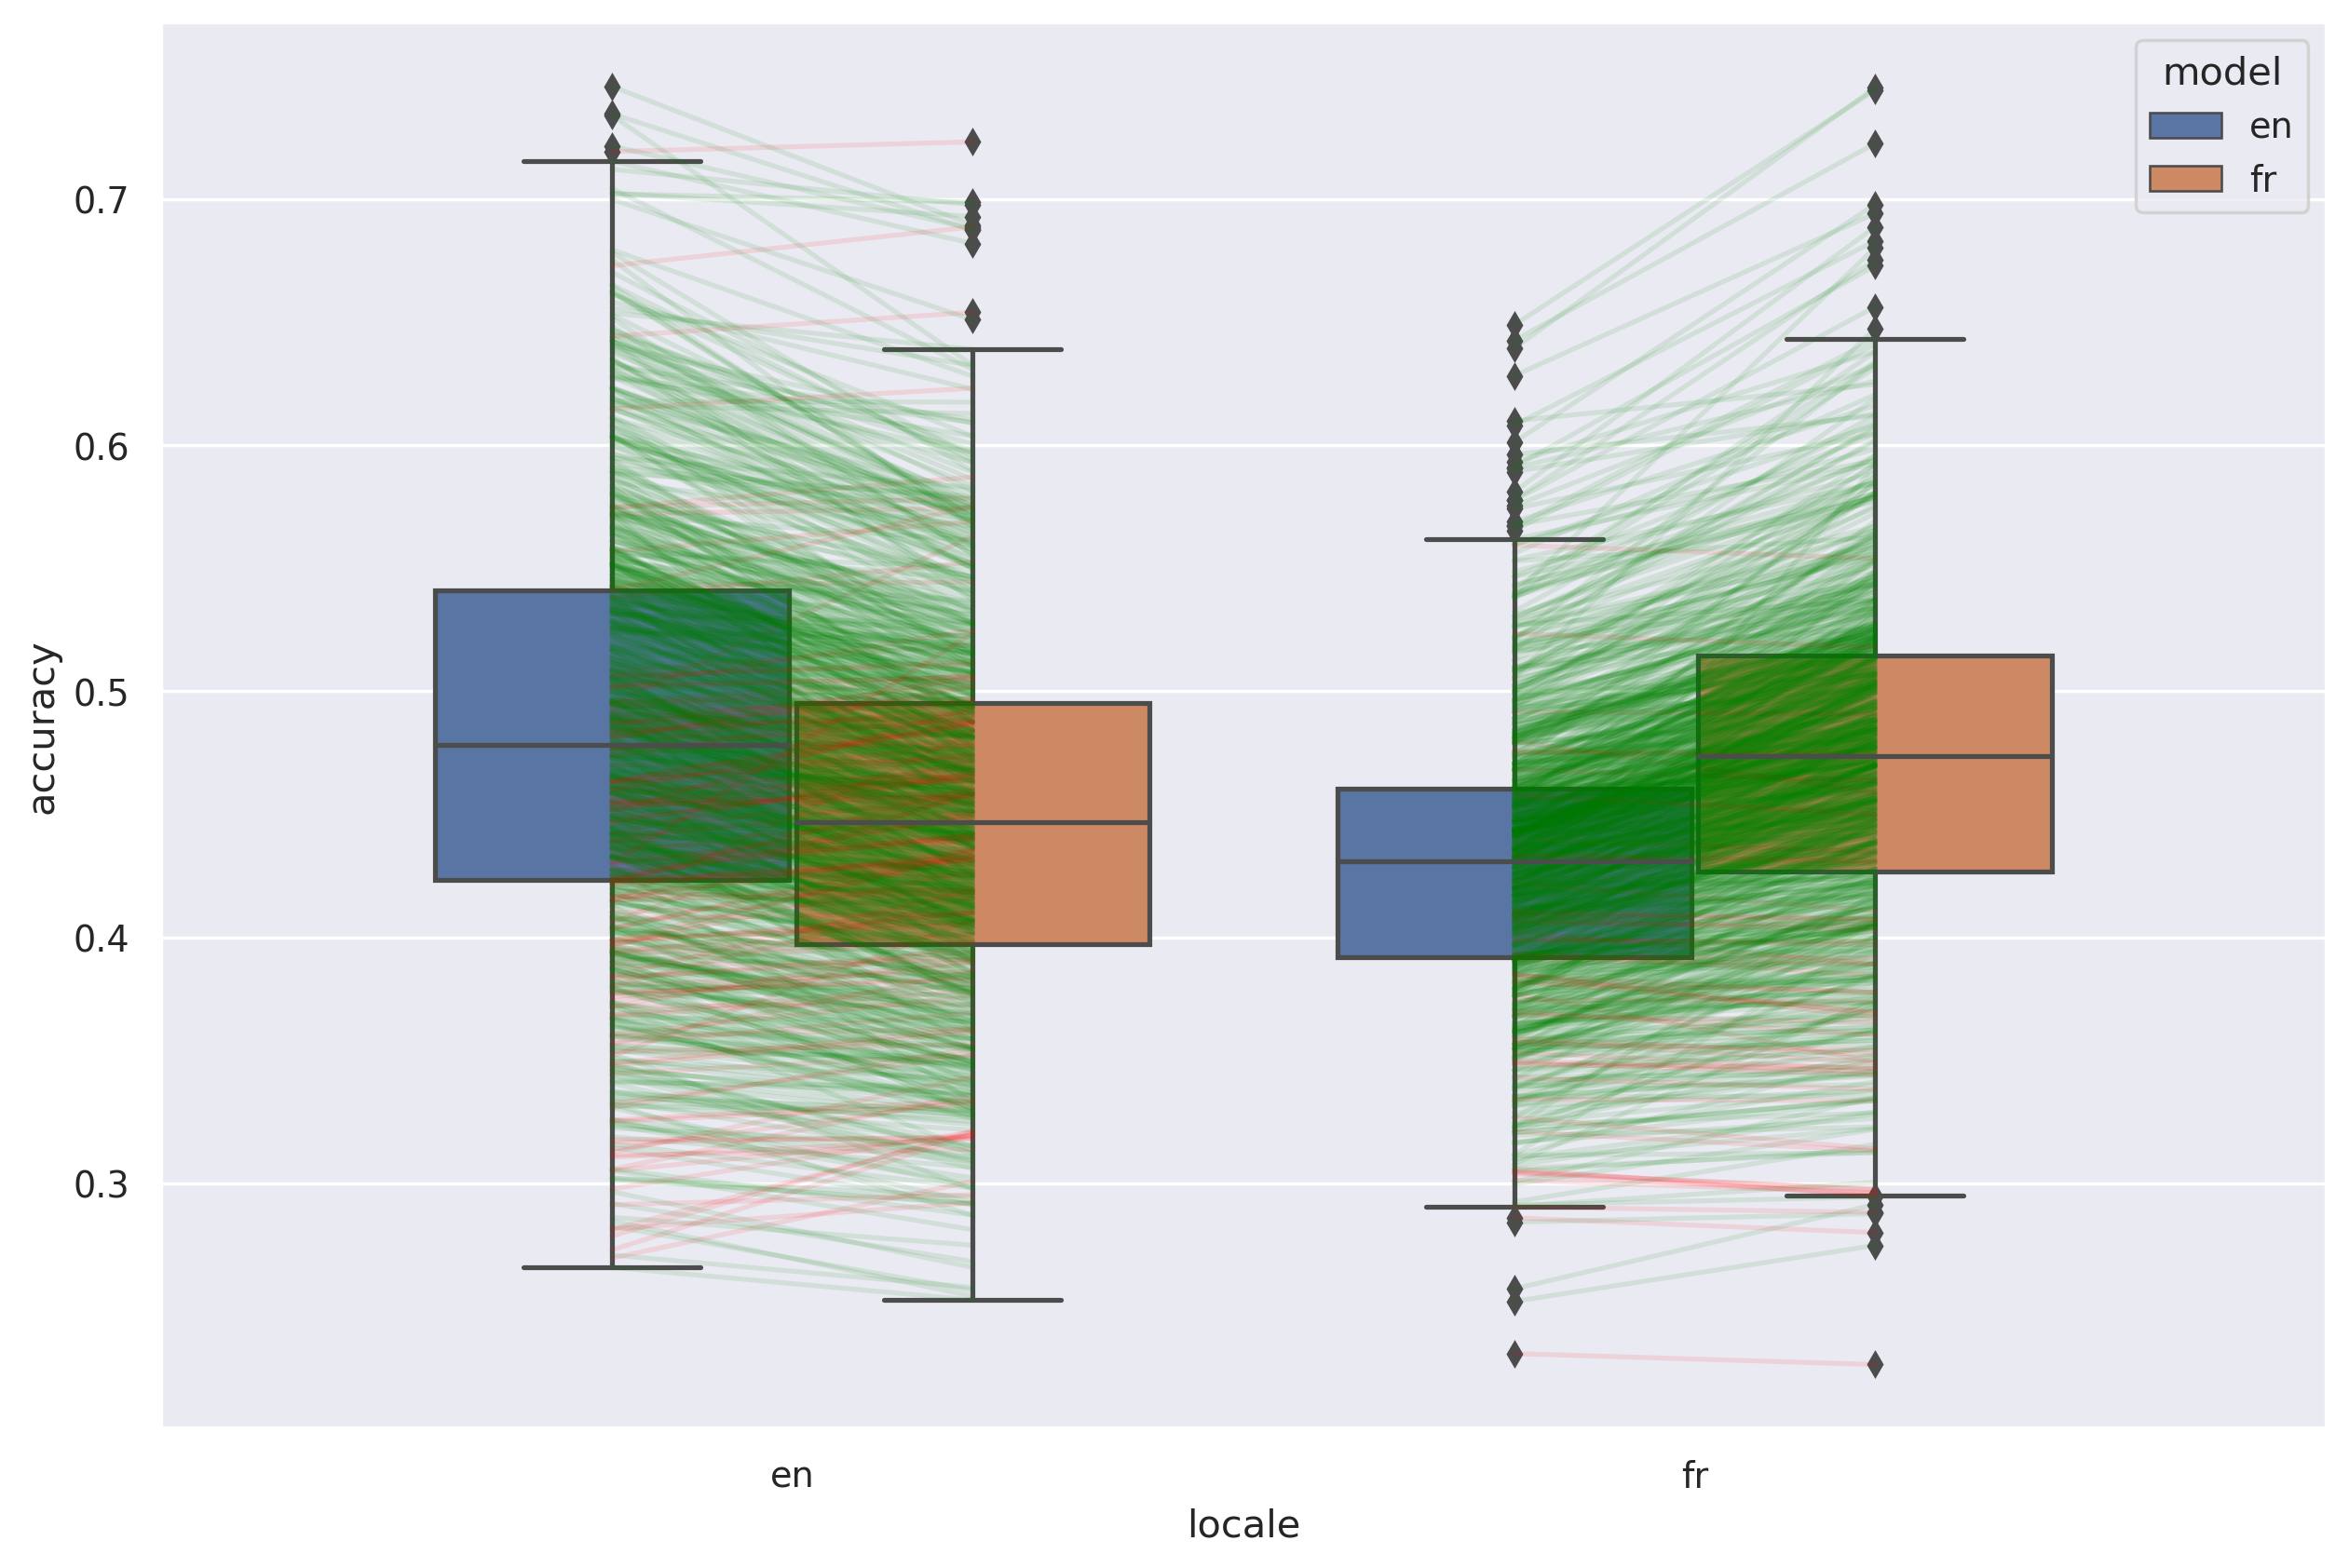

In [107]:
sns.boxplot(x="locale", y = "accuracy", hue='model' ,order=['en', 'fr'], data=df)


native_best_en = 0
nonnative_best_en = 0
native_best_fr = 0
nonnative_best_fr = 0
for a,y in zip(df.groupby('audio')["accuracy"].apply(list).index, df.groupby('audio')["accuracy"].apply(list)):

    if df[df['audio'] == a].locale.unique()[0] == "en":
        x = [-0.2,0.2]
        if y[0] > y[1]:
            col = "green"
            native_best_en+=1
            
        else:
            col="red"
            nonnative_best_en+=1
    else:
        x = [0.8,1.2]
        if y[0] < y[1]:
            col = "green"
            native_best_fr+=1
            
        else:
            col="red"
            nonnative_best_fr+=1
    
    plt.plot(x,y, color=col, alpha = 0.1)
print(native_best_en,nonnative_best_en)
print(native_best_fr,nonnative_best_fr)
print(native_best_en + native_best_fr,nonnative_best_en+nonnative_best_fr)

<AxesSubplot:xlabel='locale', ylabel='accuracy'>

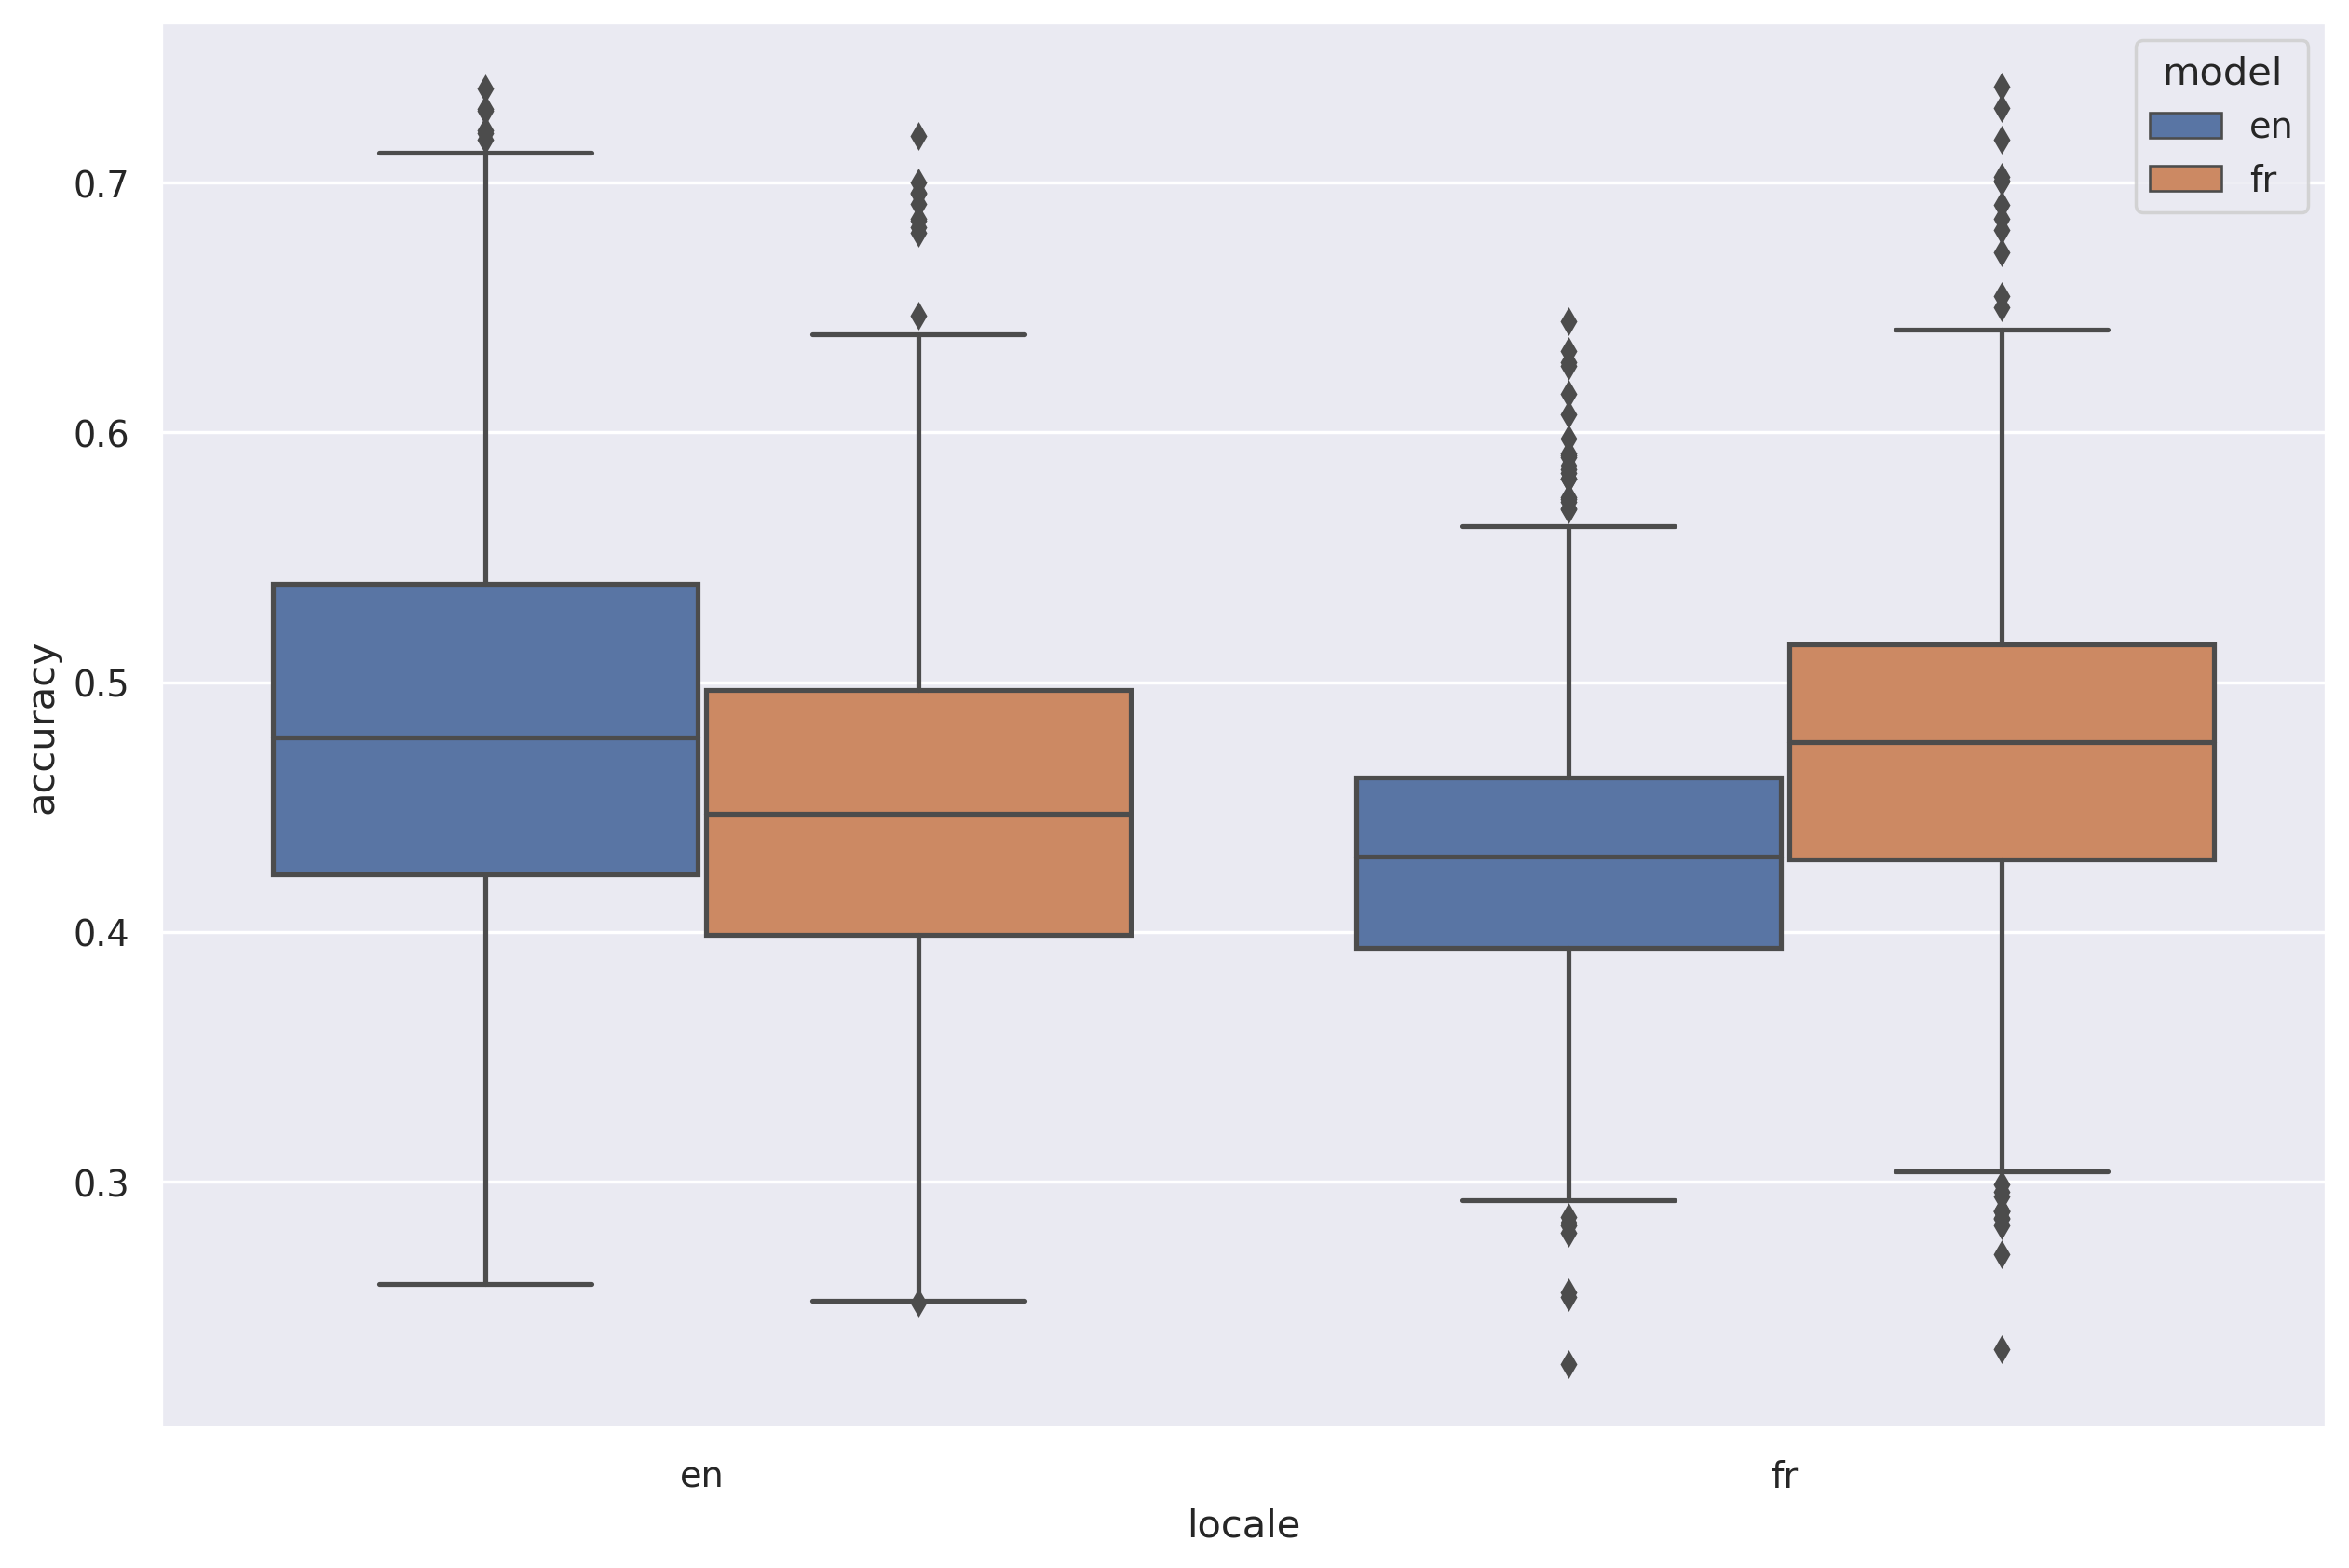

In [71]:
sns.boxplot(x="locale", y = "accuracy", hue='model' ,order=['en', 'fr'] ,data=df)

<AxesSubplot:xlabel='model', ylabel='accuracy'>

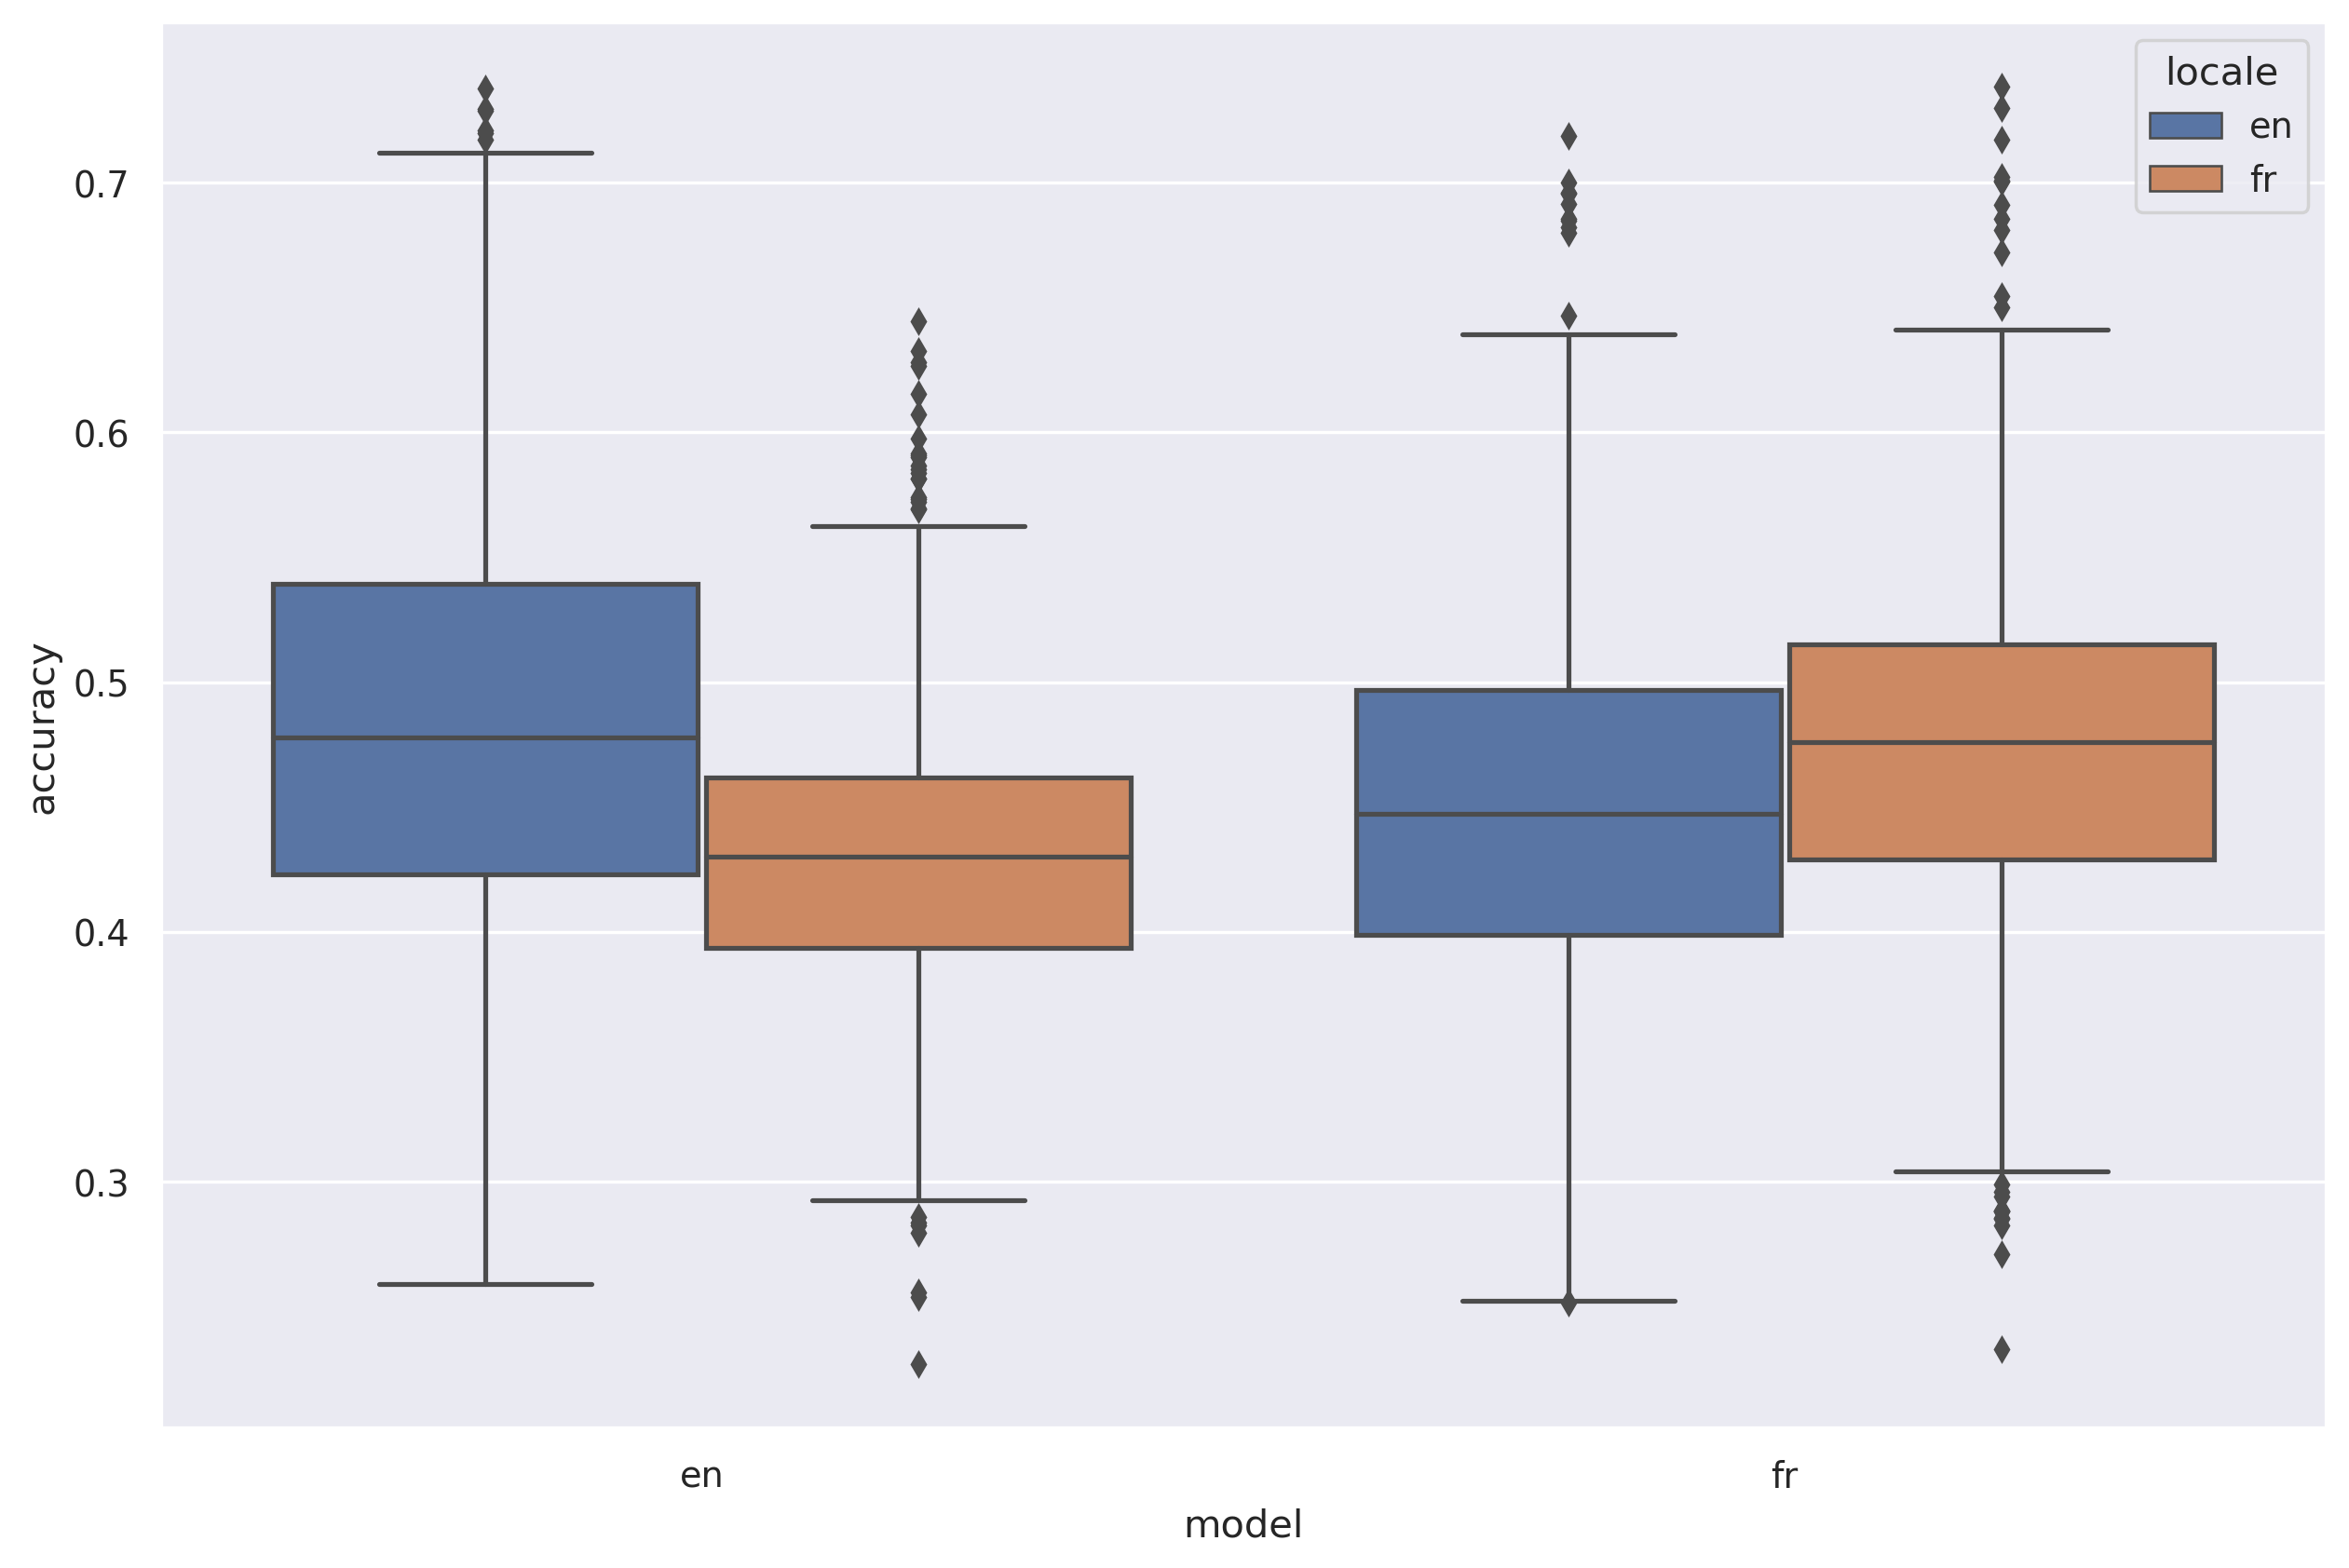

In [68]:
sns.boxplot(x="model", y = "accuracy", hue='locale' ,data=df)

## Here I do the opposite, I look at for a model the native preference of a language

<AxesSubplot:xlabel='model', ylabel='accuracy'>

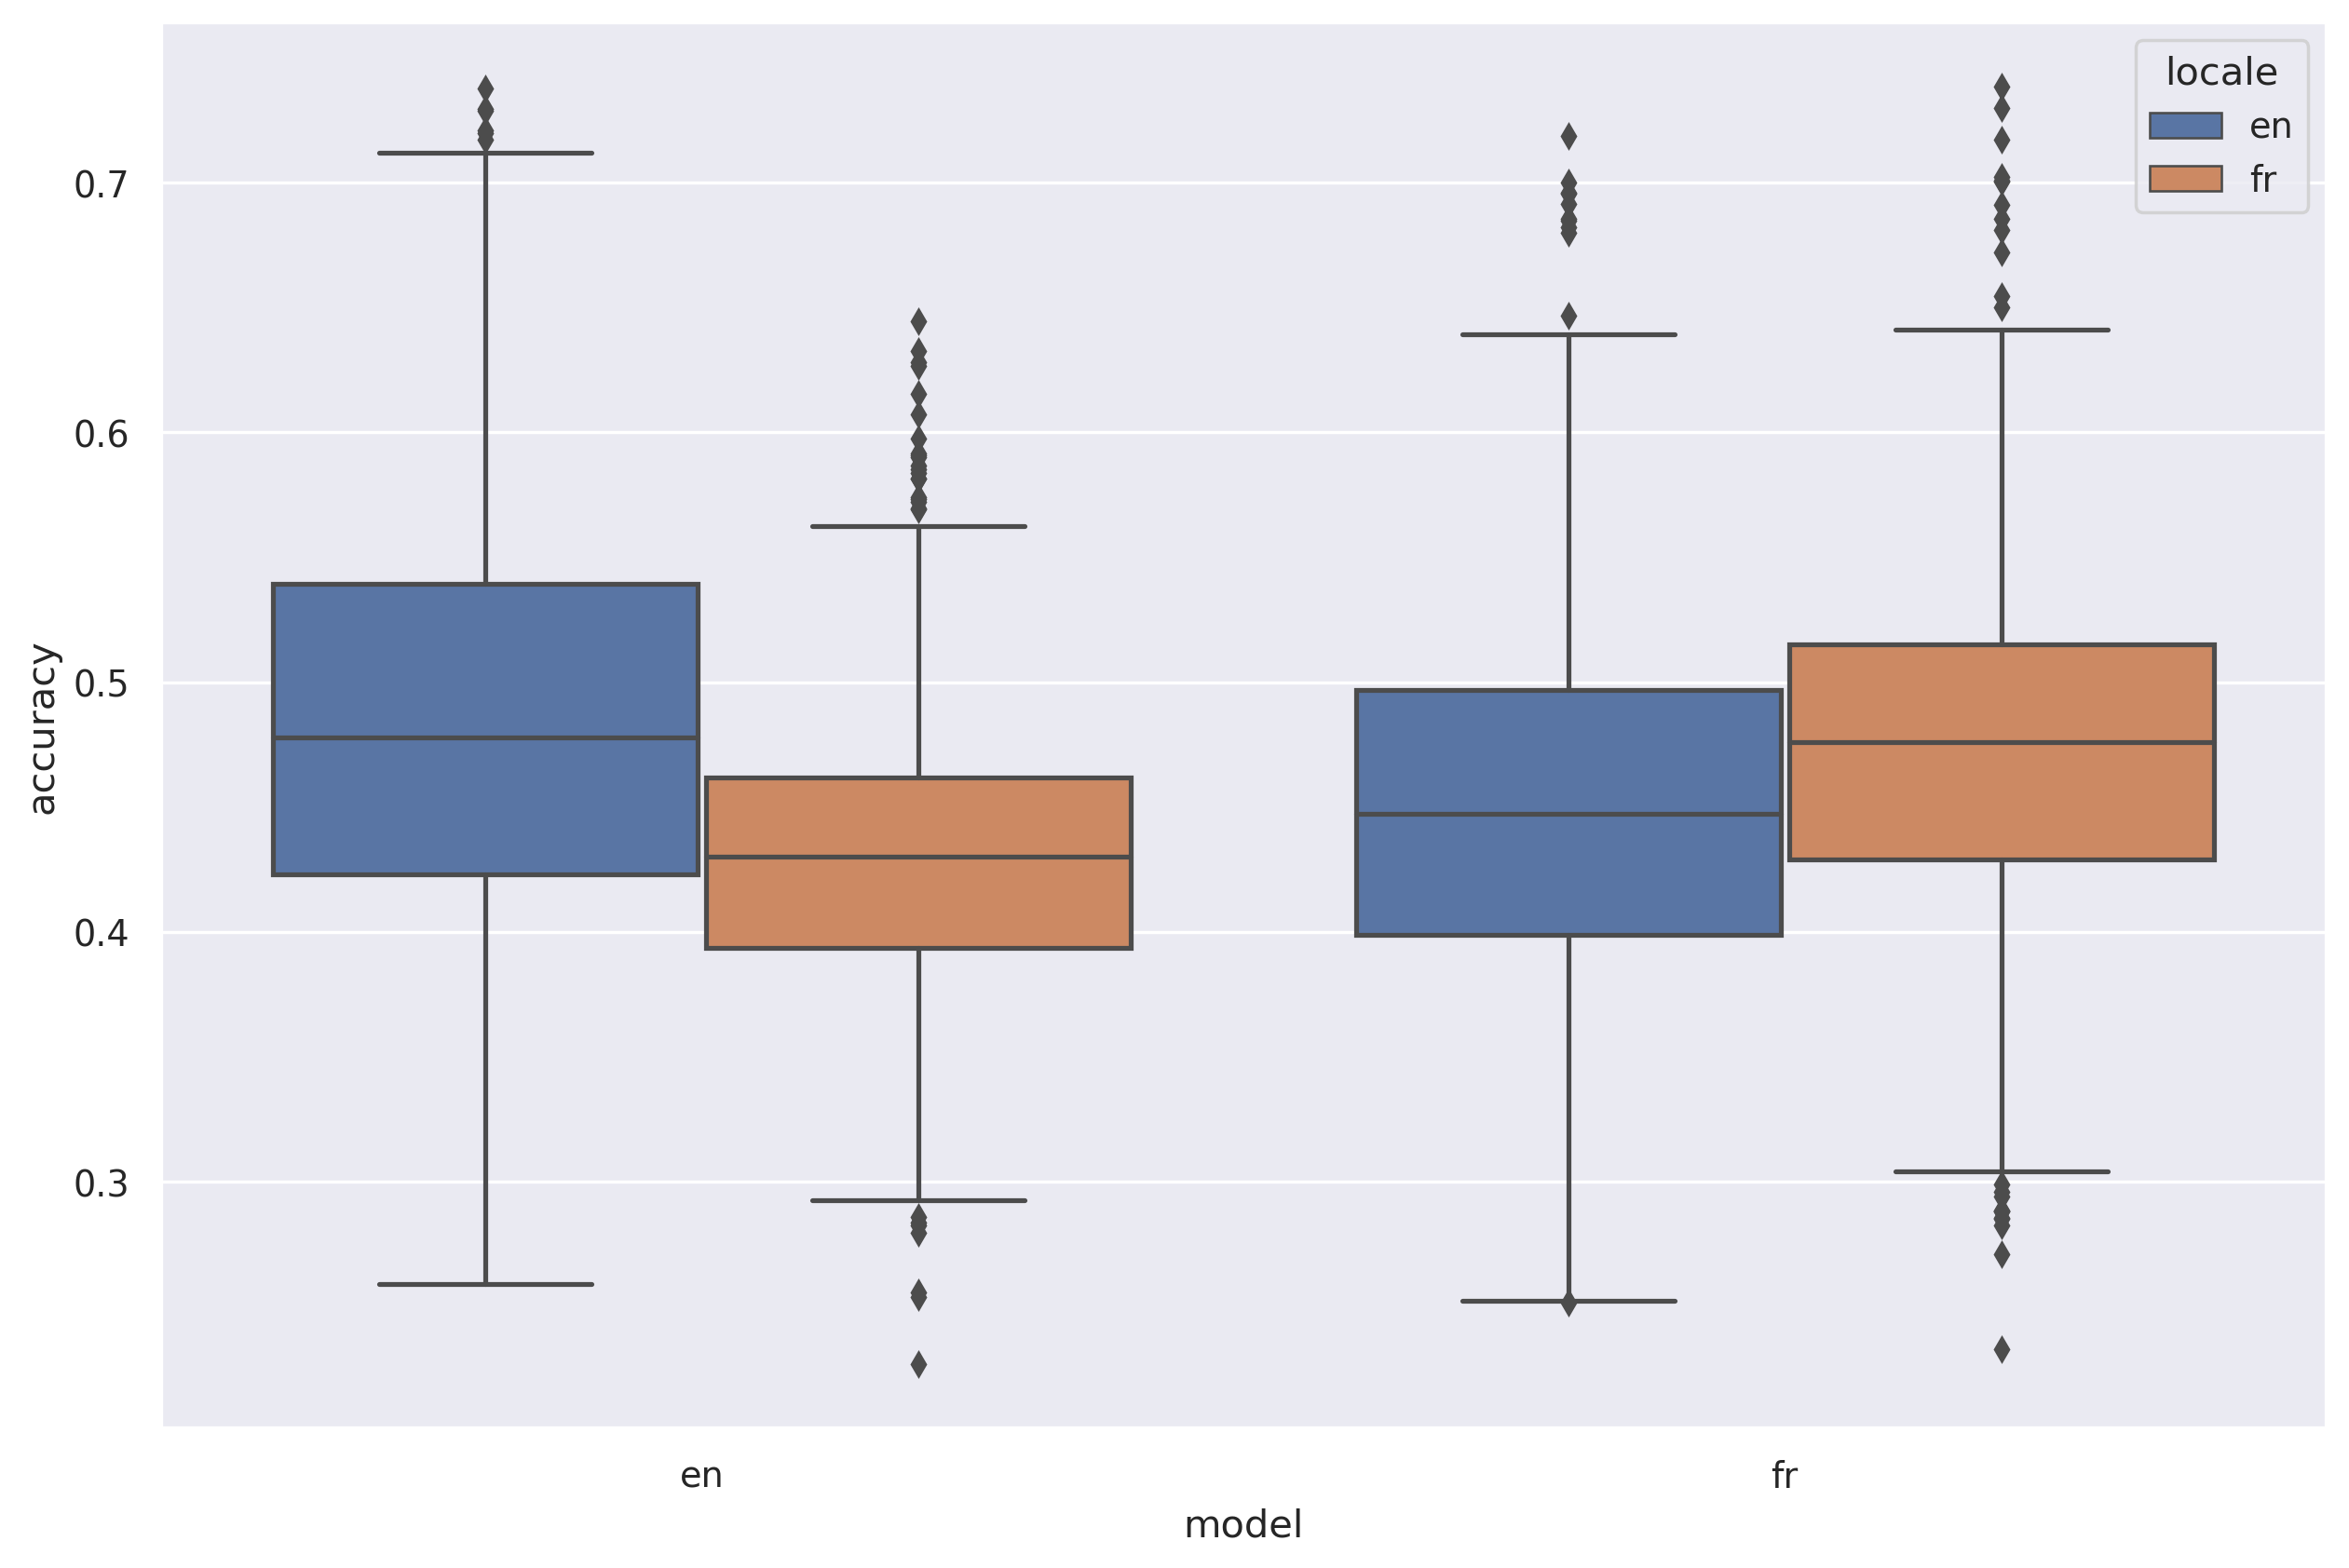

In [70]:
sns.boxplot(x="model", y = "accuracy", hue='locale' ,data=df)

<AxesSubplot:xlabel='model', ylabel='accuracy'>

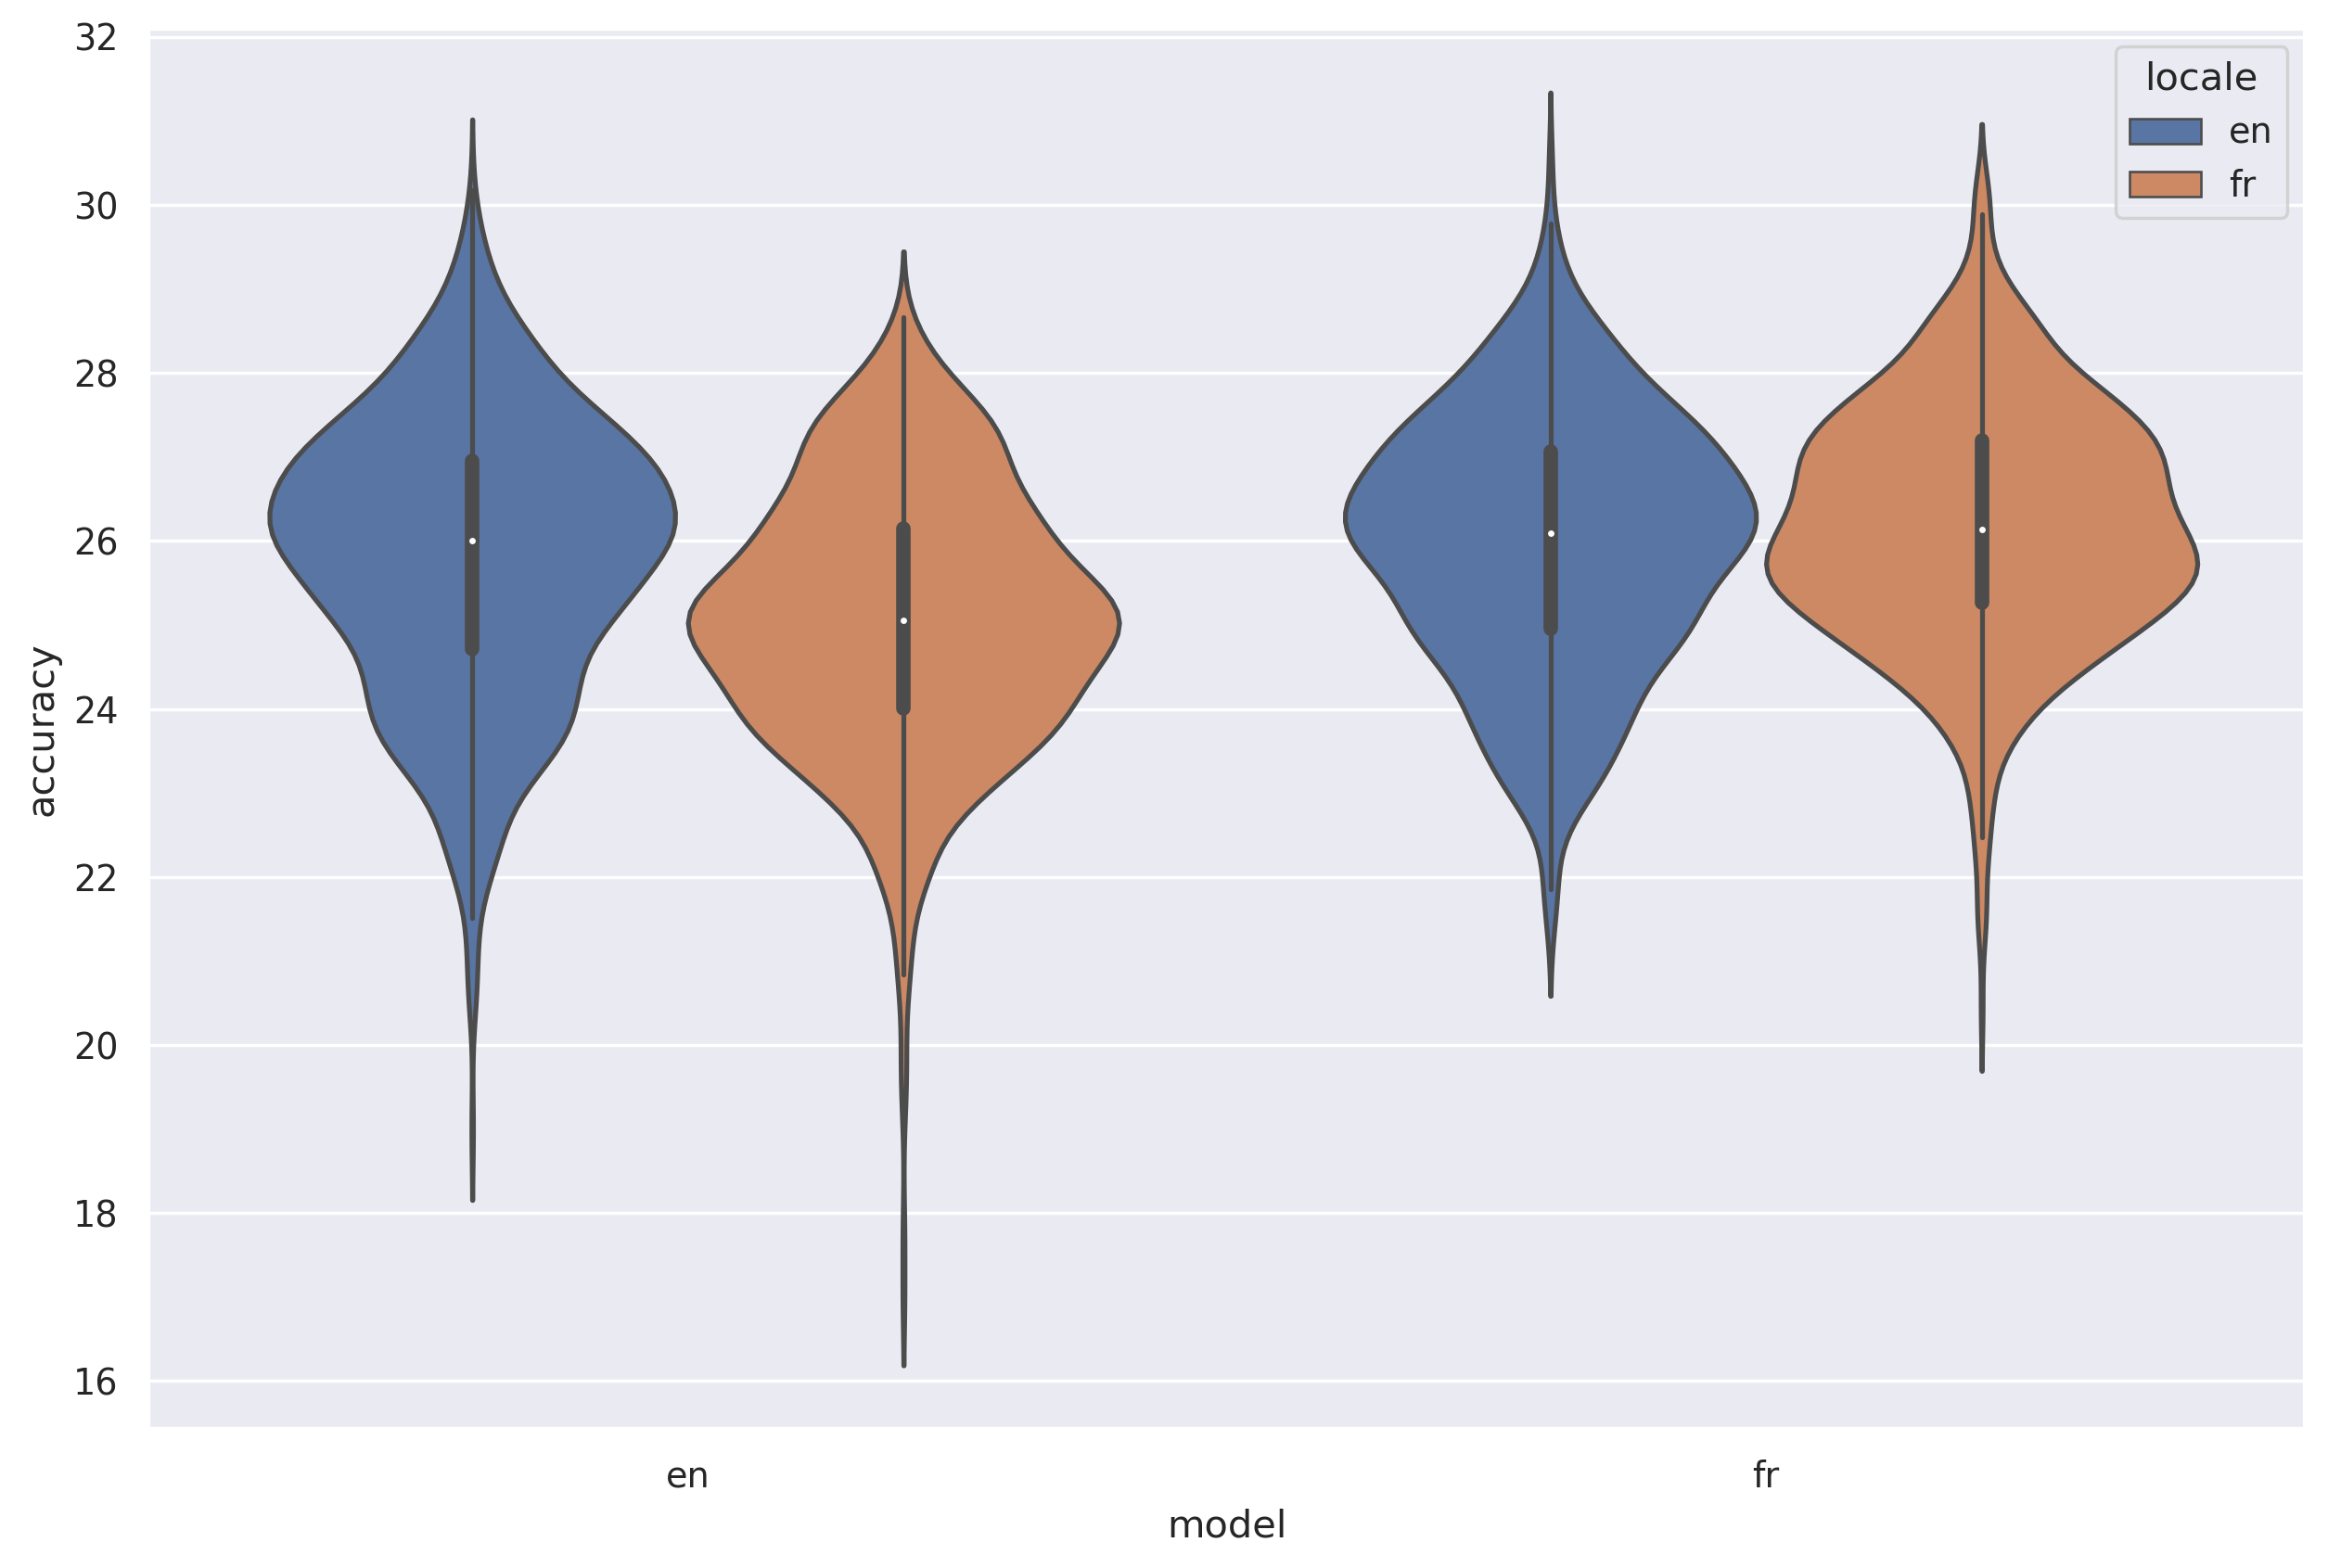

In [162]:
sns.violinplot(x="locale", y = "model", hue='locale' ,data=df)

array([<AxesSubplot:title={'center':'acc_en'}, xlabel='[locale]'>,
       <AxesSubplot:title={'center':'acc_fr'}, xlabel='[locale]'>],
      dtype=object)

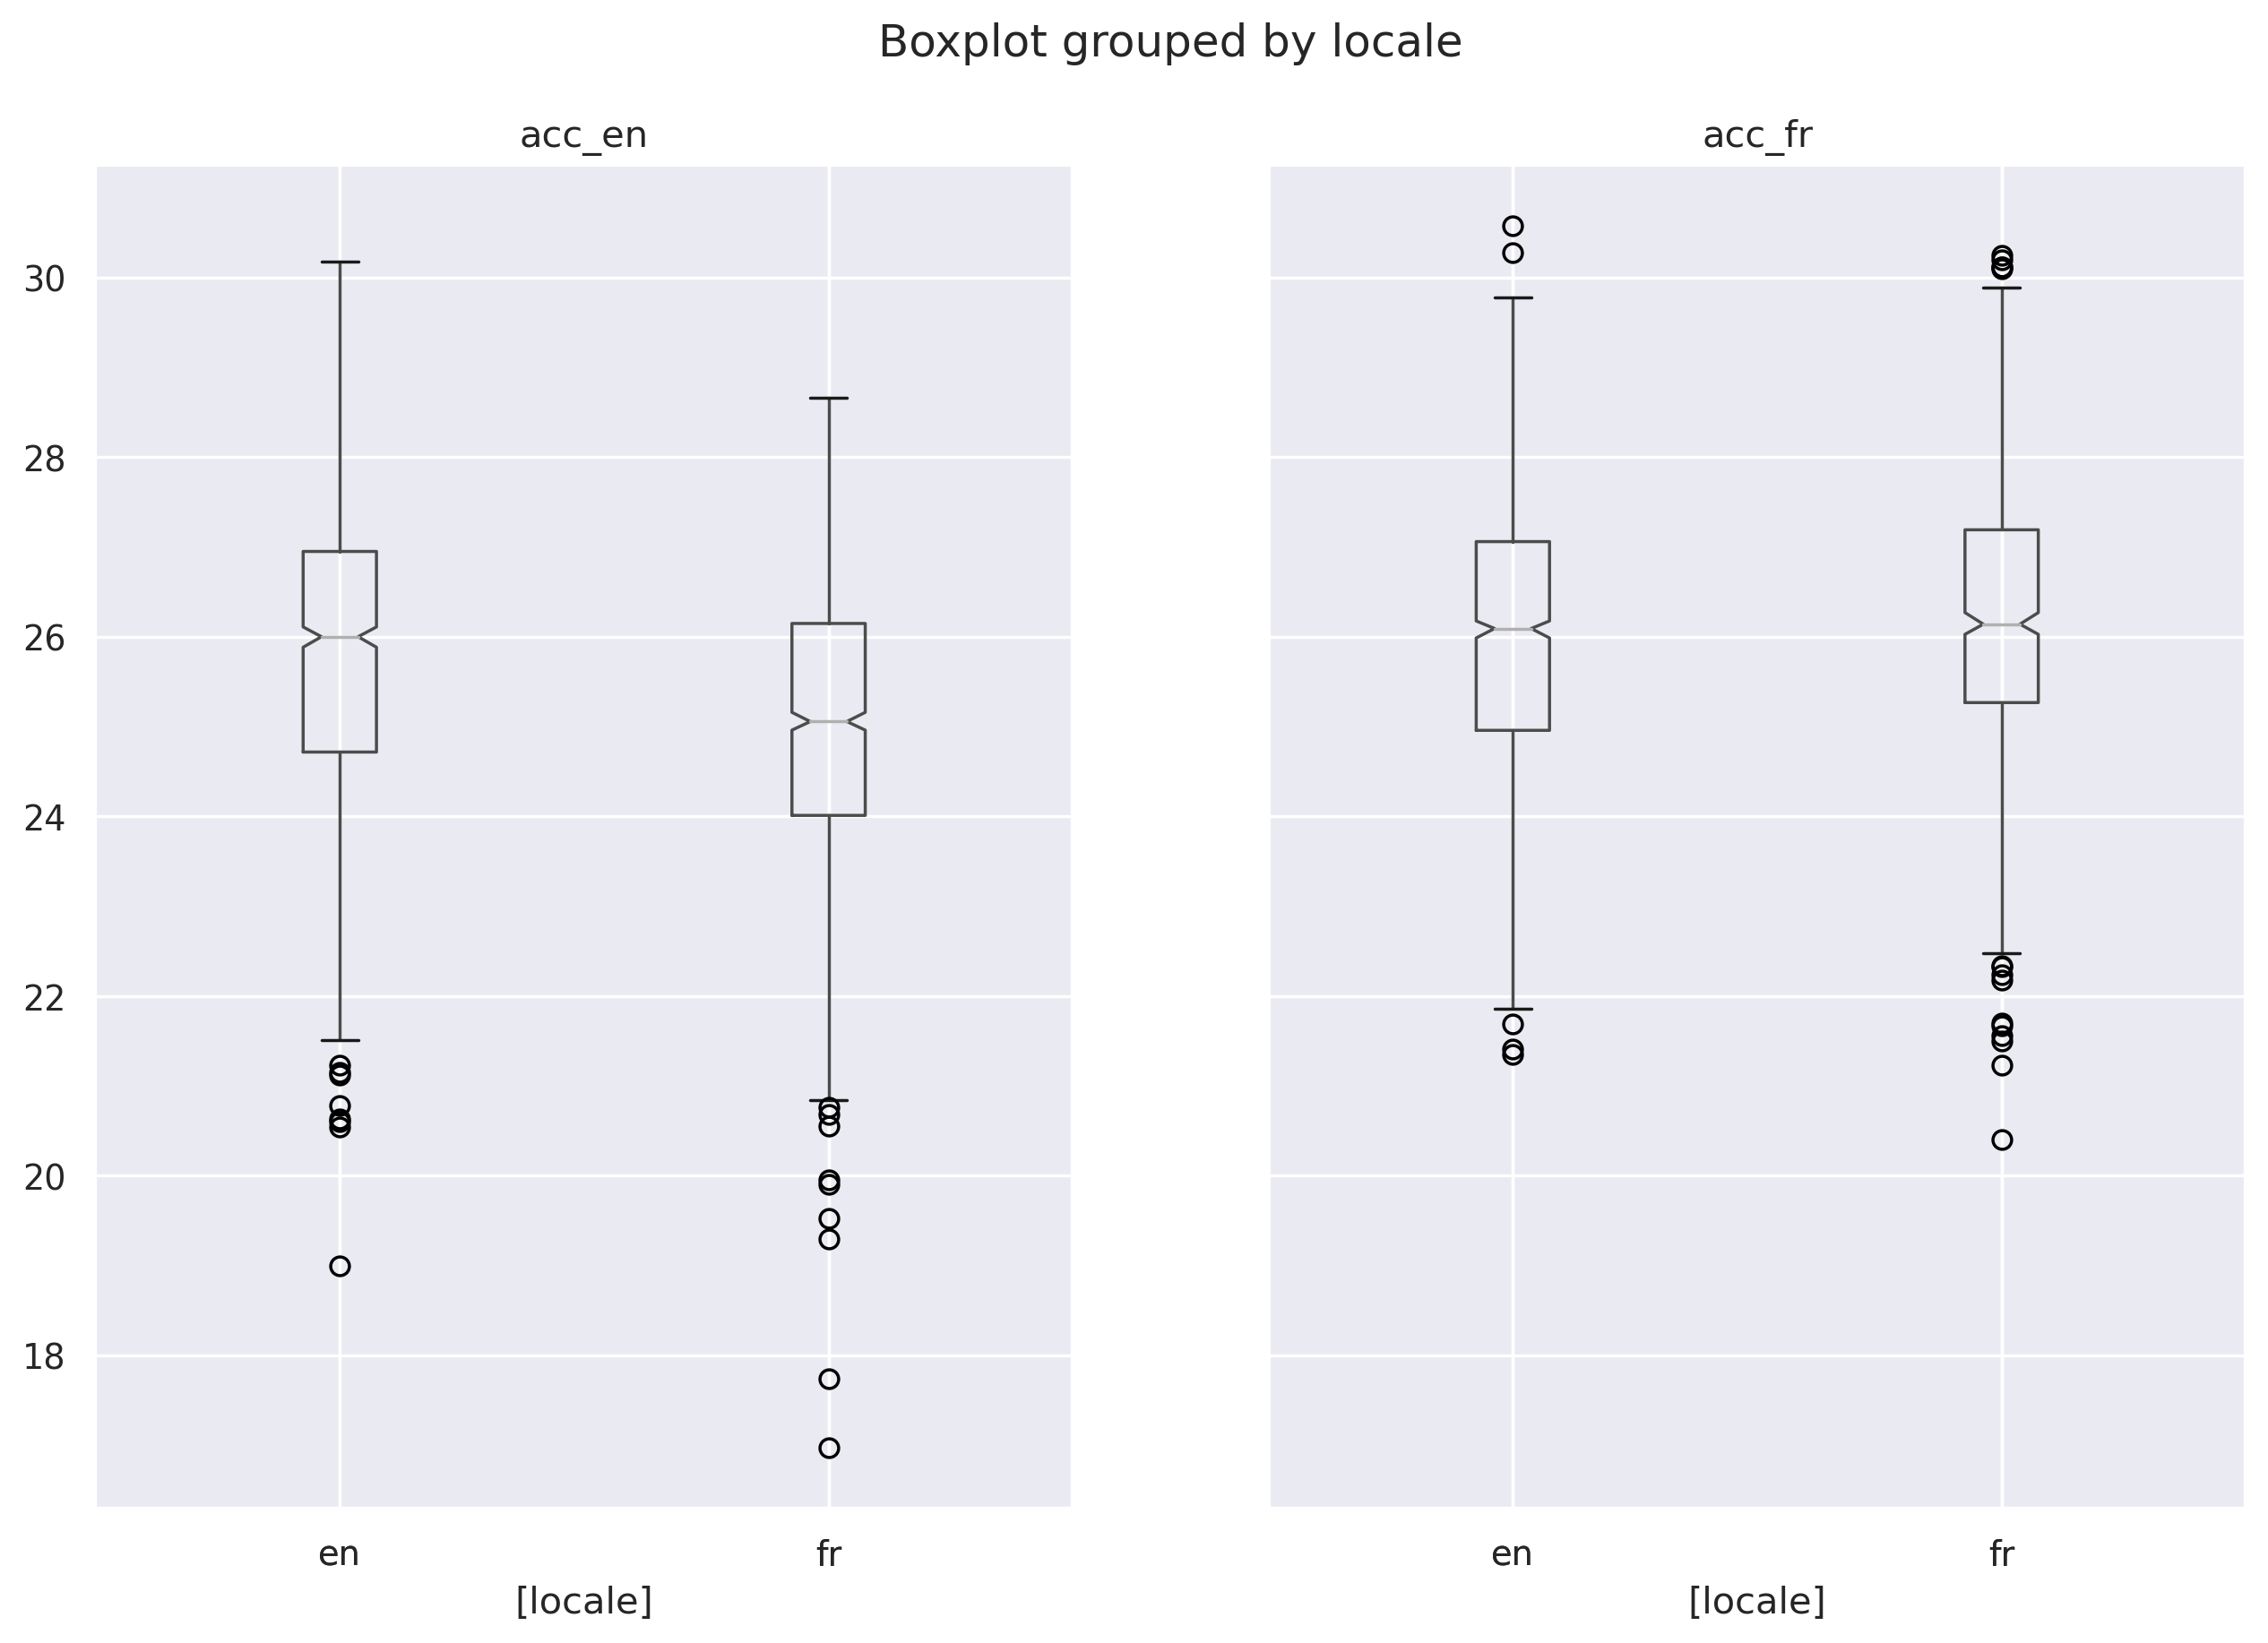

In [99]:
df.boxplot(column=['acc_en', 'acc_fr'], by = ['locale'], notch=True, bootstrap=1000)

In [ ]:
df.boxplot(column=['model_en', 'model_fr'], by = ['locale'], notch=True, bootstrap=1000)

In [ ]:
df[df["locale"]=="en"]

Ttest_indResult(statistic=6.87985899253518, pvalue=8.001142779471258e-12)

In [18]:
stats.ttest_ind(df[df["locale"]=="en"]["model_en"], df[df["locale"]=="fr"]["model_en"], equal_var=False)

Ttest_indResult(statistic=8.031053215078503, pvalue=1.6424855827314628e-15)

In [19]:
stats.ttest_ind(df[df["locale"]=="en"]["model_fr"], df[df["locale"]=="fr"]["model_fr"], equal_var=False)

Ttest_indResult(statistic=-4.6440834982316455, pvalue=3.6366015685754105e-06)

In [63]:
df[df['locale'] == "fr"].log_prob_fr.mean()

-1216.7799798310693

In [64]:
df[df['locale'] == "en"].log_prob_fr.mean()

-1303.3059023902529

### Bilingual model

In [86]:
cv_test_np = "/gpfsdswork/projects/rech/ank/ucv88ce/projects/data_preparation/commonvoice/CV_Inftrain_test/data/native_pref/native_pref.tsv"
root_audio = '/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_dataset/'

df = pd.read_csv(cv_test_np, sep="\t")

df['audio'] = df.apply(lambda x : os.path.join(root_audio, x.locale, x.path.split('.')[0]+".wav"), axis=1)
df = df.drop(['Unnamed: 0', 'up_votes', 'down_votes', 'segment'], axis=1) #remove useless columns


In [87]:
lang2cpc = {}

#EN
pathCheckpoint = "/gpfsssd/scratch/rech/cfs/commun/InfTrain_models/EN/3200h/00/cpc_small/checkpoint_25.pt"
cpcModel, cpcCriterion = load_model_criterion(pathCheckpoint)
lang2cpc['en'] = (cpcModel, cpcCriterion)

#FR
pathCheckpoint = "/gpfsssd/scratch/rech/cfs/commun/InfTrain_models/FR/3200h/00/cpc_small/checkpoint_20.pt"
cpcModel, cpcCriterion = load_model_criterion(pathCheckpoint)
lang2cpc['fr'] = (cpcModel, cpcCriterion)

#EN+FR
pathCheckpoint = "/gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/checkpoints/inftrain/EN+FR/3200h/00/cpc_small/checkpoint_25.pt"
cpcModel, cpcCriterion = load_model_criterion(pathCheckpoint)
lang2cpc['bil'] = (cpcModel, cpcCriterion)



Loading checkpoint /gpfsssd/scratch/rech/cfs/commun/InfTrain_models/EN/3200h/00/cpc_small/checkpoint_25.pt
Loading checkpoint /gpfsscratch/rech/cfs/commun/InfTrain_models/EN/3200h/00/cpc_small/checkpoint_20.pt
Loading the state dict at /gpfsssd/scratch/rech/cfs/commun/InfTrain_models/EN/3200h/00/cpc_small/checkpoint_25.pt
Activating multi-head rnn
CPC model and criterion loaded!
Loading checkpoint /gpfsssd/scratch/rech/cfs/commun/InfTrain_models/FR/3200h/00/cpc_small/checkpoint_20.pt
Loading checkpoint /gpfsscratch/rech/cfs/commun/InfTrain_models/FR/3200h/00/cpc_small/checkpoint_15.pt
Loading the state dict at /gpfsssd/scratch/rech/cfs/commun/InfTrain_models/FR/3200h/00/cpc_small/checkpoint_20.pt
Activating multi-head rnn
CPC model and criterion loaded!
Loading checkpoint /gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/checkpoints/inftrain/EN+FR/3200h/00/cpc_small/checkpoint_25.pt
Loading the state dict at /gpfsssd/scratch/rech/ank/ucv88ce/projects/MultilingualCPC/checkpoint

In [88]:
for lang in ["en", "fr", 'bil']:
    df['{}'.format(lang)] = df.progress_apply(lambda x : compute_score_CPC(seqPath=x.audio,cpcModel=lang2cpc[lang][0], cpcCriterion = lang2cpc[lang][1], average_total=True ), axis=1)

df  = df.melt(id_vars=['client_id', 'path', 'sentence', 'age', 'gender', 'accent', 'locale',
       'dur', 'audio', 'present'], 
        var_name="model",
        value_vars=['en',
       'fr', 'bil'],
        value_name="scores")
df = pd.concat([df, pd.DataFrame(df['scores'].to_list(), columns=["loss", "accuracy"])], axis=1)

  0%|          | 0/2016 [00:00<?, ?it/s]

  0%|          | 0/2016 [00:00<?, ?it/s]

  0%|          | 0/2016 [00:00<?, ?it/s]

In [89]:
df

,client_id,path,sentence,age,gender,accent,locale,dur,audio,present,model,scores,loss,accuracy
0,70c21ca1cc3de05f3c23b11615cd7d5dd078e03cda0cd4...,common_voice_en_20754408.mp3,The group was managed by Justin Timberlake's m...,fifties,female,us,en,4.752,/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_...,True,en,"(0.0036640288308262825, 0.5492753386497498)",0.003664,0.549275
1,1c673b0209f32b4203637065b31d919e1b6b74be2c814c...,common_voice_en_20145666.mp3,He also appeared in a commercial for the telep...,fifties,male,us,en,5.376,/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_...,True,en,"(0.004237037152051926, 0.43642449378967285)",0.004237,0.436424
2,592dc0785596d25f25089ff7c64f388cf2ea09adcb4418...,common_voice_fr_18052792.mp3,Il devint ardemment et violemment parlementaire.,thirties,male,france,fr,3.984,/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_...,True,en,"(0.005488291382789612, 0.4379340410232544)",0.005488,0.437934
3,b16aec5eaefe46b9d08bb73b705344b5e9dd18bdda5ec9...,common_voice_en_18139175.mp3,Emily wants to get her hair bleached.,twenties,female,us,en,3.456,/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_...,True,en,"(0.0061337146908044815, 0.4290030300617218)",0.006134,0.429003
4,592dc0785596d25f25089ff7c64f388cf2ea09adcb4418...,common_voice_fr_18146729.mp3,"Madame la ministre, je vous remercie de votre ...",thirties,male,france,fr,5.376,/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_...,True,en,"(0.004103486426174641, 0.45283618569374084)",0.004103,0.452836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043,669affb9d334f7759037e1e181e06bf7764a8b337a3853...,common_voice_fr_18245773.mp3,Il faudrait ajouter à la fin de l’alinéa un qu...,twenties,female,france,fr,6.336,/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_...,True,bil,"(0.002911209361627698, 0.5168282389640808)",0.002911,0.516828
6044,b16aec5eaefe46b9d08bb73b705344b5e9dd18bdda5ec9...,common_voice_en_18065623.mp3,The baby is due next week.,twenties,female,us,en,2.352,/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_...,True,bil,"(0.005630170460790396, 0.6560606360435486)",0.005630,0.656061
6045,1c5ac4e60d78e04c497fcf0631e17dc41c4194fdaf8646...,common_voice_en_27128010.mp3,"Be careful, this man is dangerous.",NaN,female,us,en,4.248,/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_...,True,bil,"(0.0064189075492322445, 0.35656073689460754)",0.006419,0.356561
6046,e2245777b14c8f4478b278e5445bb435880113722f4a11...,common_voice_fr_18392729.mp3,"un avenue Alphonse Daudet, zéro quatre, huit c...",twenties,male,france,fr,5.064,/gpfsssd/scratch/rech/cfs/commun/cv21_ABX/raw_...,True,bil,"(0.0041451058350503445, 0.458841472864151)",0.004145,0.458841


<AxesSubplot:xlabel='model', ylabel='accuracy'>

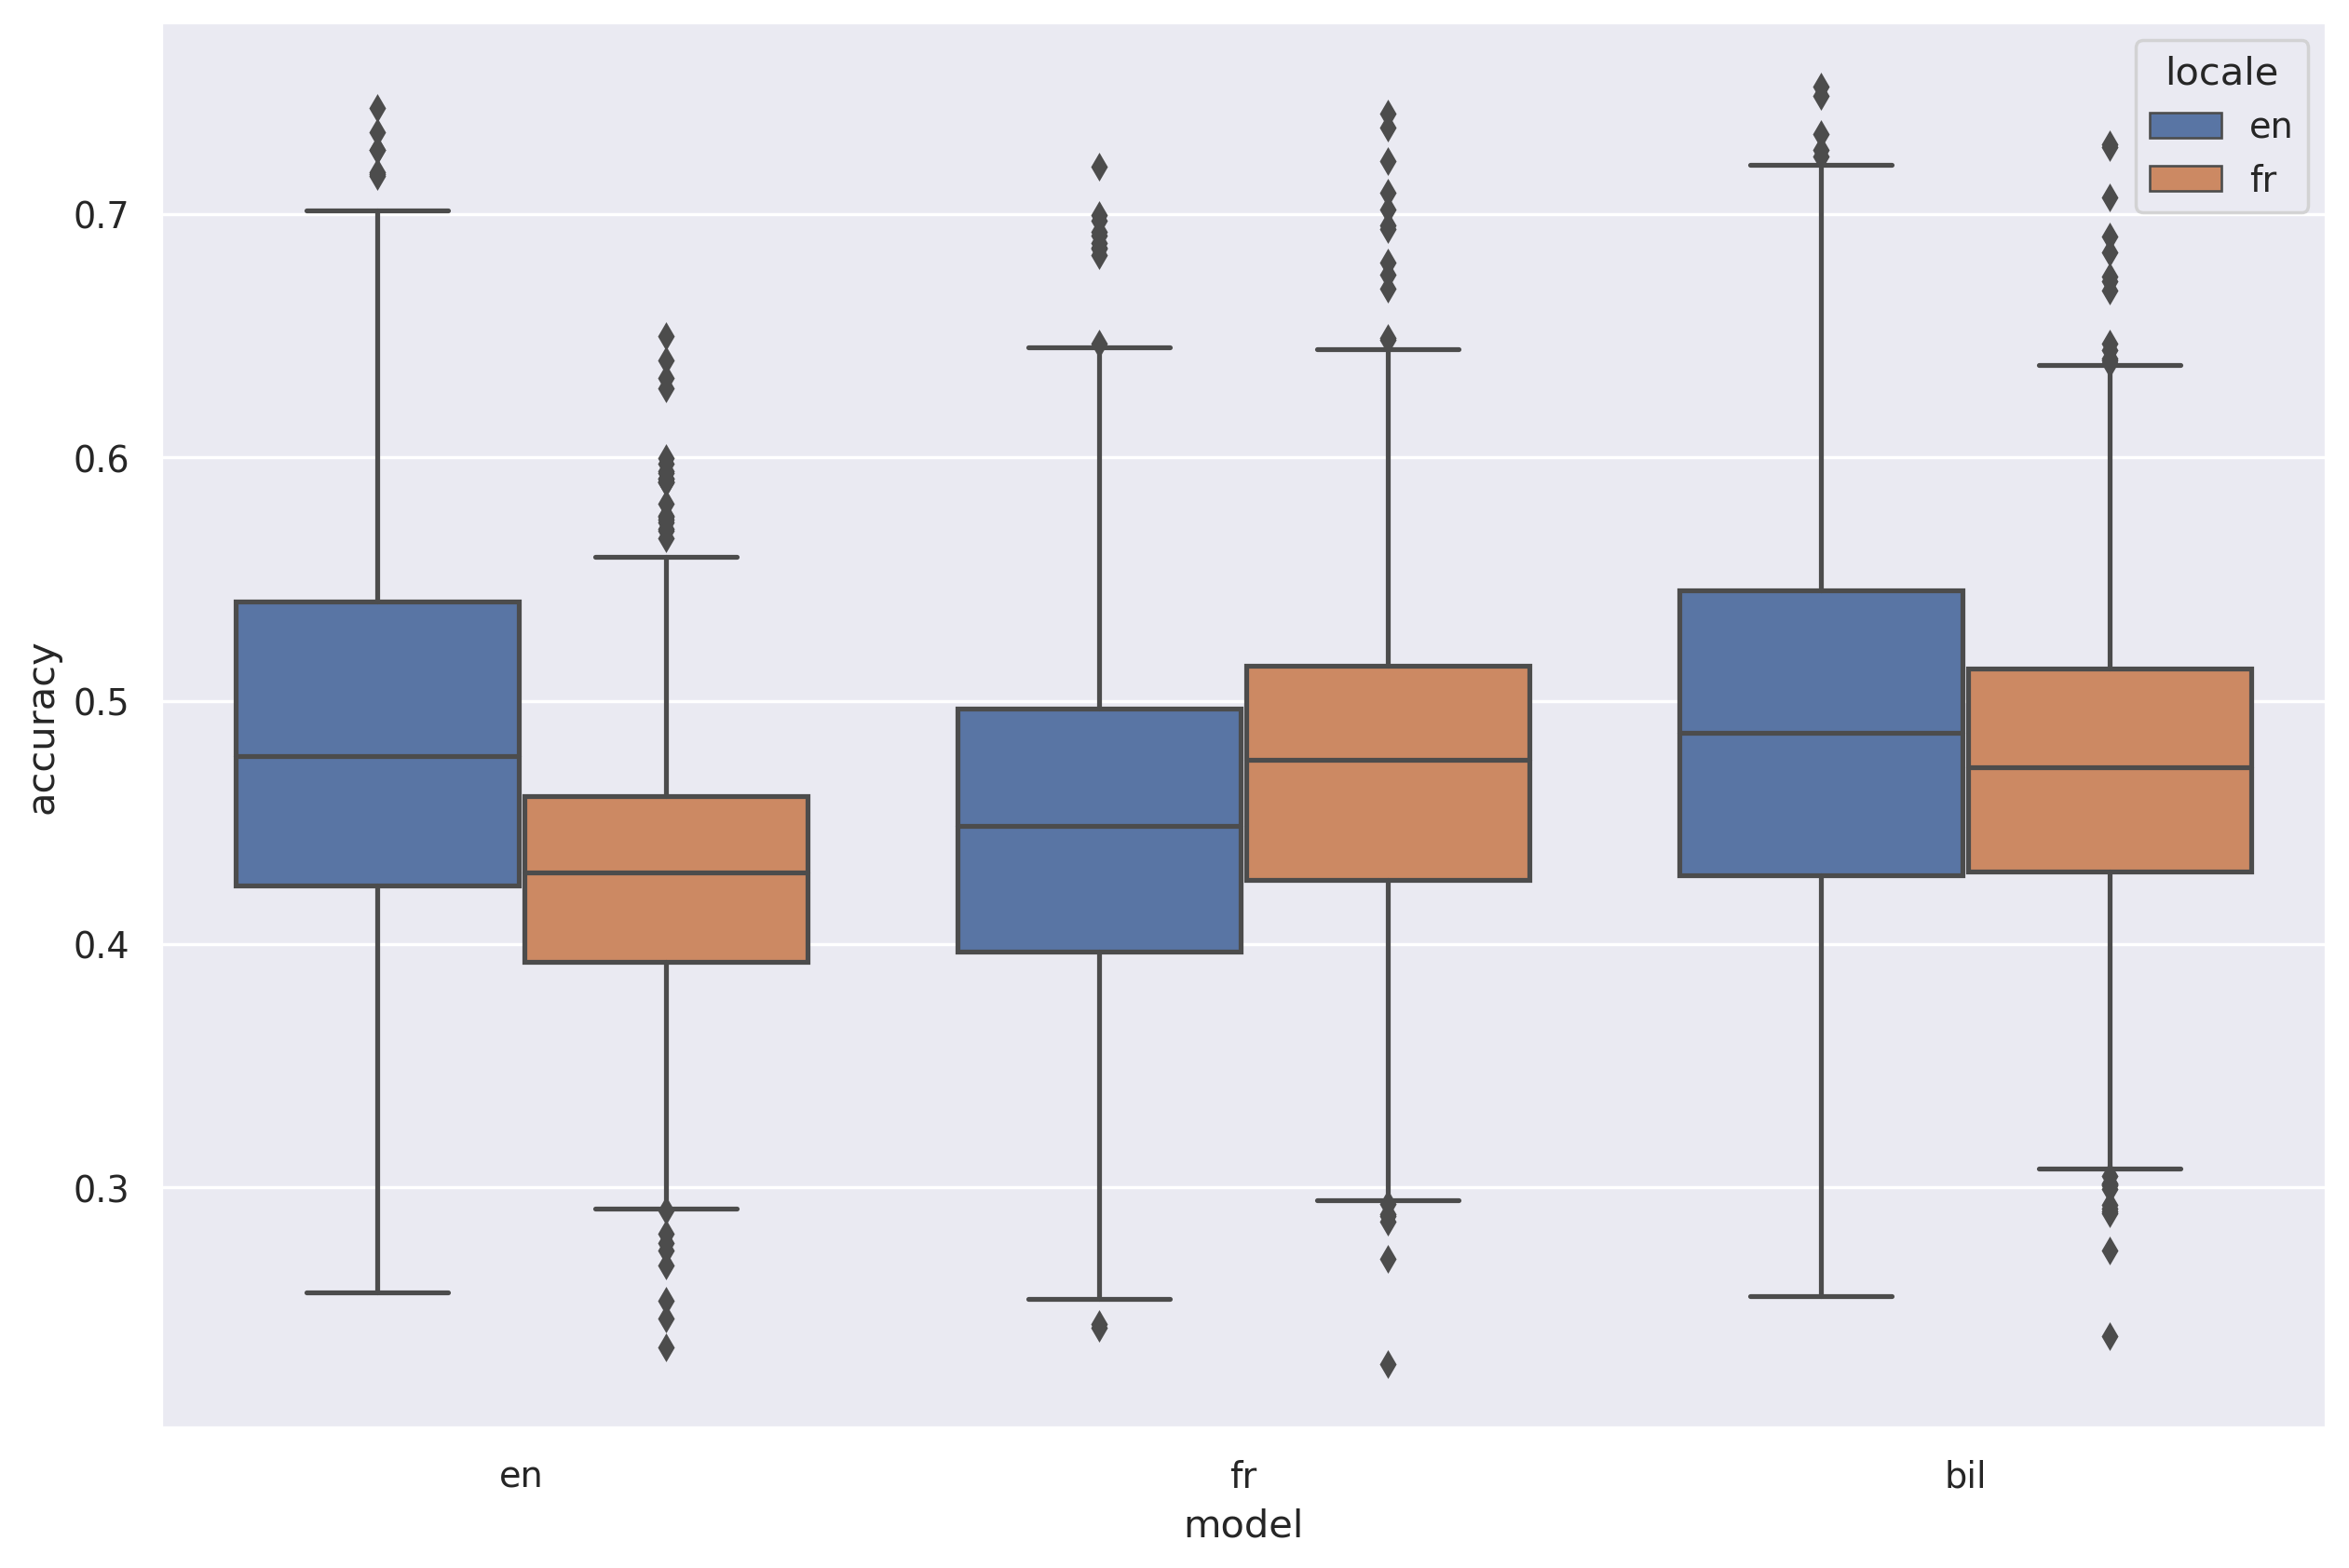

In [90]:
sns.boxplot(x="model", y = "accuracy", hue='locale' ,order=['en', 'fr', 'bil'], data=df)

In [94]:
stats.ttest_ind(df[(df["locale"]=="en") & (df["model"]=="bil")]["accuracy"],df[(df["locale"]=="fr") & (df["model"]=="bil")]["accuracy"], equal_var=False)

Ttest_indResult(statistic=4.2519721322470785, pvalue=2.222233622622284e-05)

<AxesSubplot:xlabel='locale', ylabel='accuracy'>

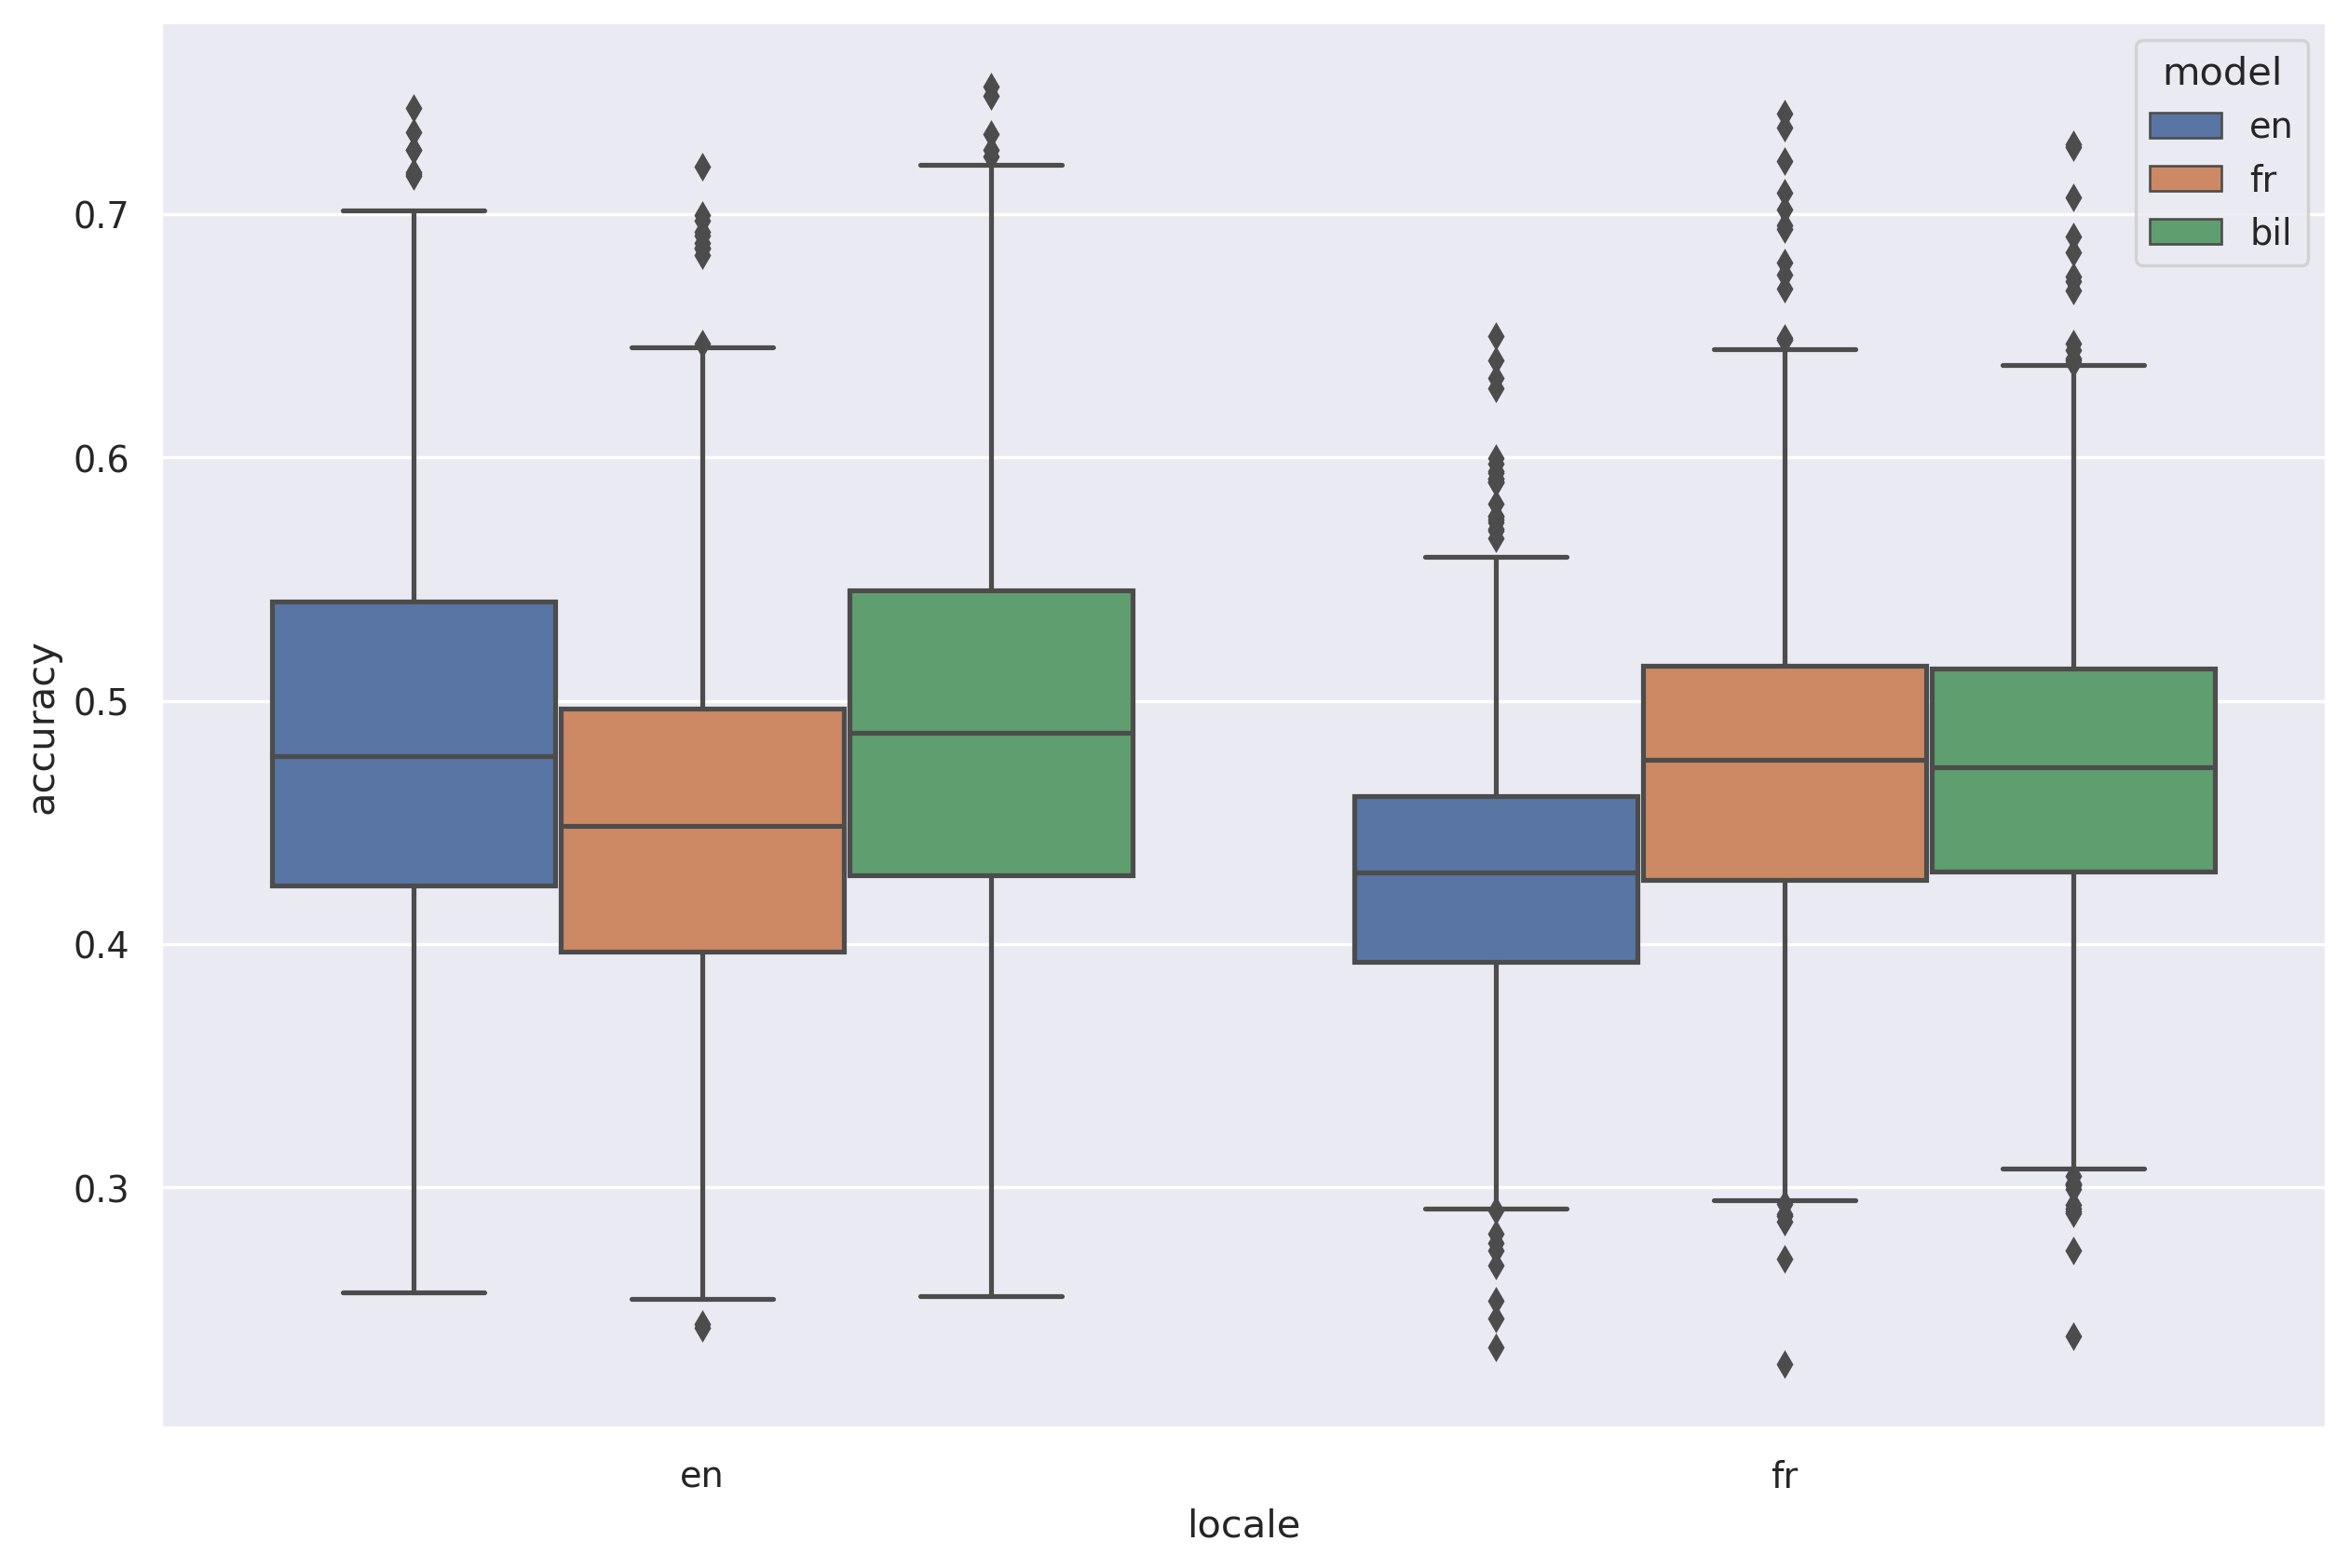

In [91]:
sns.boxplot(x="locale", y = "accuracy", hue='model' , data=df)

In [95]:
stats.ttest_ind(df[(df["locale"]=="en") & (df["model"]=="bil")]["accuracy"],df[(df["locale"]=="en") & (df["model"]=="en")]["accuracy"], equal_var=False)

Ttest_indResult(statistic=1.4638162806105037, pvalue=0.14340024343133223)

In [96]:
stats.ttest_ind(df[(df["locale"]=="en") & (df["model"]=="bil")]["accuracy"],df[(df["locale"]=="fr") & (df["model"]=="fr")]["accuracy"], equal_var=False)

Ttest_indResult(statistic=4.3221551514554575, pvalue=1.6239780033581985e-05)